# cfDNA mixtures series on chr 22

In [61]:
# Imports

%load_ext autoreload
%autoreload 2

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import warnings
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix

# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.viz import *
from utils.table import *
from utils.metrics import *
from utils.calltable import *
from utils.venn import venn6, get_labels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [62]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
set_display_params(config)

paper


In [63]:
# Chomosome

chrom = '22'
muttype = 'snv'
mixtureid =  'CRC-123_310715-CW-T_CRC-123_121115-CW-T' # 'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T' # 'CRC-986_100215-CW-T_CRC-986_300316-CW-T'
plasmasample = '_'.join(mixtureid.split('_')[:2])
print(plasmasample)
healthysample = '_'.join(mixtureid.split('_')[2:])
print(healthysample)

CRC-123_310715-CW-T
CRC-123_121115-CW-T


# Load call table

In [65]:
# Save table if do not exist and load tables

calltables = {'sampleid':[], 'tf':[], 'cov':[], 'snv':[], 'indel':[], 'snp':[]}
mixturefolder = os.path.join(*config.mixturefolder, 'mixtures_chr'+chrom, 'mixtures_chr'+chrom+'_'+mixtureid)
for mixturepath in [l for l in os.listdir(mixturefolder) if l.endswith('x') or l.endswith('T')]:
    # if mixturepath != 'mixture_chr22_CRC-1014_180816-CW-T_30x_CRC-1014_090516-CW-T_120x'  and mixturepath != 'mixture_chr22_CRC-1014_180816-CW-T_20x_CRC-1014_090516-CW-T_130x':
    print(mixturepath)
    if not os.path.exists(os.path.join(mixturefolder, mixturepath, 'calls', mixturepath+'_snv_calls_PASS.csv')):
        calltable_snv, calltable_indel, calltable_snp = get_calltable(os.path.join(mixturefolder, mixturepath), config.methods, save=True, filter='PASS')
    calltables['sampleid'].append(mixturepath)
    #calltables['tf'].append(np.round(100*float(pd.read_csv(os.path.join(mixturefolder, mixturepath, 'estimated_tf_chr'+chrom+mixturepath[len(('mixture_chr'+chrom)):]+'.txt')).columns[0]), 4))
    calltables['cov'].append(np.round(100*float(pd.read_csv(os.path.join(mixturefolder, mixturepath, 'coverage_chr'+chrom+mixturepath[len(('mixture_chr'+chrom)):]+'.txt')).columns[0]), 4))
    calltable_snv = pd.read_csv(os.path.join(mixturefolder, mixturepath, 'calls', mixturepath+'_snv_calls_PASS.csv'), index_col=0)
    calltable_indel = pd.read_csv(os.path.join(mixturefolder, mixturepath, 'calls', mixturepath+'_indel_calls_PASS.csv'), index_col=0)
    calltable_snp = pd.read_csv(os.path.join(mixturefolder, mixturepath, 'calls', mixturepath+'_snp_calls_PASS.csv'), index_col=0)
    calltables['snv'].append(calltable_snv)
    calltables['indel'].append(calltable_indel)
    calltables['snp'].append(calltable_snp)
calltables.keys()

mixture_chr22_CRC-123_310715-CW-T_70x_CRC-123_121115-CW-T_180x
mixture_chr22_CRC-123_310715-CW-T_20x_CRC-123_121115-CW-T_130x
mixture_chr22_CRC-123_310715-CW-T_20x_CRC-123_121115-CW-T_130x
freebayes
mutect2
strelka2
vardict
varscan
abemus
sinvict
                  chrom       pos ref alt type  freebayes  freebayes_score  \
chrom_pos_ref_alt                                                            
22_16050116_G_C      22  16050116   G   C  SNV      False              NaN   
22_16050159_C_T      22  16050159   C   T  SNV      False              NaN   
22_16050252_A_T      22  16050252   A   T  SNV      False              NaN   
22_16050408_T_C      22  16050408   T   C  SNV      False              NaN   
22_16053090_G_C      22  16053090   G   C  SNV      False              NaN   

                   mutect2  mutect2_score  strelka2  ...  vardict_vaf  \
chrom_pos_ref_alt                                    ...                
22_16050116_G_C      False            NaN     False  ...    

dict_keys(['sampleid', 'tf', 'cov', 'snv', 'indel', 'snp'])

In [67]:
calltables['tf'] = [30, 10, 3, 13, 15, 45, 6, 15, 1.5, 20]

In [68]:
for mt in ['snv', 'indel', 'snp']:
    if not os.path.exists(os.path.join(mixturefolder, 'calls')):
        os.mkdir(os.path.join(mixturefolder, 'calls'))
    if not os.path.exists(os.path.join(mixturefolder, 'calls', mixtureid+'_'+mt+'_calls_PASS.csv')):
        for ci, csnv in enumerate(calltables[mt]):
            cols = ['chrom', 'pos', 'ref', 'alt', 'type']
            for m in config.methods:
                cols.append('{:.2f}_{}'.format(calltables['tf'][ci], m))
                cols.append('{:.2f}_{}_score'.format(calltables['tf'][ci], m))
            for m in config.methods:
                cols.append('{:.2f}_{}_altcov'.format(calltables['tf'][ci], m)) 
                cols.append('{:.2f}_{}_totcov'.format(calltables['tf'][ci], m)) 
                cols.append('{:.2f}_{}_vaf'.format(calltables['tf'][ci], m)) 
            csnv.columns = cols
        # ensure no duplicated index
        print(calltables[mt][0].loc[calltables[mt][0].index[calltables[mt][0].index.duplicated(keep=False)]].shape[0])
        # get call series
        calltablesseries = pd.concat([ct.set_index(['chrom', 'pos', 'ref', 'alt', 'type']) for ct in calltables[mt]], axis=1)
        calltablesseries.reset_index(inplace=True)
        calltablesseries['chrom_pos_ref_alt'] = calltablesseries['chrom'].astype('str').str.cat(calltablesseries['pos'].astype('str'), sep="_").str.cat(calltablesseries['ref'].astype('str'), sep='_').str.cat(calltablesseries['alt'].astype('str'), sep='_')
        calltablesseries.set_index('chrom_pos_ref_alt', inplace=True)
        print(calltablesseries.shape)
        calltablesseries.to_csv(os.path.join(mixturefolder, 'calls', mixtureid+'_'+mt+'_calls_PASS.csv'))
        
calltablesseries = pd.read_csv(os.path.join(mixturefolder, 'calls', mixtureid+'_'+muttype+'_calls_PASS.csv'), index_col=0)
calltablesseries.head()

0
(131131, 355)
0
(31292, 355)
0
(91621, 355)


,chrom,pos,ref,alt,type,30.00_freebayes,30.00_freebayes_score,30.00_mutect2,30.00_mutect2_score,30.00_strelka2,...,20.00_vardict_vaf,20.00_varscan_altcov,20.00_varscan_totcov,20.00_varscan_vaf,20.00_abemus_altcov,20.00_abemus_totcov,20.00_abemus_vaf,20.00_sinvict_altcov,20.00_sinvict_totcov,20.00_sinvict_vaf
chrom_pos_ref_alt,,,,,,,,,,,,,,,,,,,,,
22_16050116_G_C,22,16050116,G,C,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,150.0,0.180000
22_16050159_C_T,22,16050159,C,T,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,233.0,0.403433
22_16050252_A_T,22,16050252,A,T,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,275.0,0.367273
22_16050408_T_C,22,16050408,T,C,SNV,False,NaN,False,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.0,285.0,0.470175
22_16050517_C_T,22,16050517,C,T,SNV,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
print(calltables['tf'])
print(len(list(calltablesseries.columns)))
print(len(np.unique(list(calltablesseries.columns))))

[30, 10, 3, 13, 15, 45, 6, 15, 1.5, 20]
355
355


# Plot curves

In [70]:
calltablesseries['truth'] = False
truthpos = list(calltablesseries[calltablesseries[['{:.2f}_{}'.format(max(calltables['tf']), m) for m in config.methods]].sum(axis=1) >= 3].index)
calltablesseries.loc[truthpos, 'truth'] = True
calltablesseries['truth'].value_counts()

False    130853
True        278
Name: truth, dtype: int64

In [71]:
dilutionseries = [(70,0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]

results_auprc_df = metric_curve(config, calltablesseries, plasmasample, healthysample, dilutionseries,
                                    metric='auprc', ground_truth_method=3, refsample='undiluted', muttype=muttype, chrom=chrom, methods=config.methods, save=True)
results_recall_df = metric_curve(config, calltablesseries, plasmasample, healthysample, dilutionseries,
                                    metric='recall', ground_truth_method=3, refsample='undiluted', muttype=muttype, chrom=chrom, methods=config.methods, save=True)
results_precision_df = metric_curve(config, calltablesseries, plasmasample, healthysample, dilutionseries,
                                    metric='precision', ground_truth_method=3, refsample='undiluted', muttype=muttype, chrom=chrom, methods=config.methods, save=True)

EmptyDataError: No columns to parse from file

In [72]:
figure_curve(config, calltablesseries, plasmasample, healthysample, dilutionseries, xy='pr', ground_truth_method=3,
             refsample='undiluted', muttype=muttype.upper(), chrom='22', methods=None, save=True)

EmptyDataError: No columns to parse from file

# Confusion matrix

# Call set similarity: Jaccard Index

In [ ]:

for sklearn.metrics.jaccard_similarity_score(y_true, y_pred, normalize=True)

In [37]:
dilutionseries = [(70,0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]

patient = '1014'

if patient == '809':
    plasmasample1 = 'CRC-809_110914'
    plasmasample2 = 'CRC-809_030915'
    tumorsample1 = 'NCC_CRC-809_290714-T1W'
    plasmasampleltb = None
    healthysamples = ['pooledhealthy']
elif patient == '986':
    plasmasample1 = 'CRC-986_100215'
    plasmasample2 = 'CRC-986_261016'
    tumorsample1 = 'NCC_CRC-986_100215-T1W'
    plasmasampleltb = 'CRC-986_300316'
    healthysamples = ['pooledhealthy', 'pooledhealthy_986_filter_snv', plasmasampleltb]
elif patient == '1014':
    plasmasample2 = 'CRC-1014_110116'
    tumorsample1 = None
    plasmasampleltb = 'CRC-1014_090516'
    healthysamples = ['pooledhealthy', plasmasampleltb]
    
healthysample = healthysamples[-1]
    
if patient == '1014':
    vcf_ref_path = 'data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf'
else:
    vcf_ref_path = None

print(patient, healthysamples)
dilutionseries = [(1,0), (1, 0.72), (0.75, 0.765), (0.5, 0.81), (0.25, 0.855), (0.125, 0.875), (0.0625, 0.88)]
for i, d in dilutionseries:
    tb_dict = {}
    for i, d in enumerate(dilutionseries):
        #tb_path = os.path.join(*config.dilutionfolder, "estimated_tf_chr22_"+plasmasample1+"_"+str(dilutionseries[i][0])+"_"+healthysample+"_"+str(dilutionseries[i][1])+".txt")
        tb_path = os.path.join(*config.dilutionfolder, "estimated_tf_chr22_"+plasmasample2+"_"+str(dilutionseries[i][0])+"_"+healthysample+"_"+str(dilutionseries[i][1])+".txt")
        if d == (70, 0) and not os.path.exists(tb_path):
            tb_path = [os.path.join(*config.dilutionfolder, f) for f in os.listdir(os.path.join(*config.dilutionfolder)) if ("estimated_tf_chr22_"+plasmasample2) and (f.endswith('_0.txt'))][0]
        tb_dict[str(dilutionseries[i])] = float(pd.read_csv(tb_path).columns[0])
print(tb_dict)

tb_dict =  {'(70, 0)': 0.45449979526423284, 
            '(70, 80)': 0.19021542447303608,
            '(50, 100)': 0.1531168888180089,
            '(30, 120)': 0.11015117236383784,
            '(20, 130)': 0.05980496272648487,
            '(10, 140)': 0.031326826579643155,
            '(5, 145)': 0.01902154244730361}
print(tb_dict)

1014 ['pooledhealthy', 'CRC-1014_090516']
{'(1, 0)': 0.45449979526423284, '(1, 0.72)': 0.19021542447303608, '(0.75, 0.765)': 0.1531168888180089, '(0.5, 0.81)': 0.11015117236383784, '(0.25, 0.855)': 0.05980496272648487, '(0.125, 0.875)': 0.031326826579643155, '(0.0625, 0.88)': 0.01902154244730361}
{'(70, 0)': 0.45449979526423284, '(70, 80)': 0.19021542447303608, '(50, 100)': 0.1531168888180089, '(30, 120)': 0.11015117236383784, '(20, 130)': 0.05980496272648487, '(10, 140)': 0.031326826579643155, '(5, 145)': 0.01902154244730361}


In [41]:
dilutionseries = [(70,0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]

for i, d in enumerate(dilutionseries):
    print(i, d)
    d0 = str(d[0]).replace('.', '_')
    d1 = str(d[1]).replace('.', '_')
    path_folder="~/Repositories/cfdna_snv_benchmark/data/callers_output/mixtures/mixtures_chr22/mixture_chr22_CRC-1014_180816-CW-T_"+str(d[0])+"x_CRC-1014_090516-CW-T_"+str(d[1])+"x.sorted/abemus"
    path_file="pmtab_F3_optimalR_mixture_chr22_CRC-1014_180816-CW-T_"+str(d[0])+"x_CRC-1014_090516-CW-T_"+str(d[1])+"x.sorted.tsv"
    #path_folder="~/Repositories/cfdna_snv_benchmark/data/abemus_output/abemus_outdir_chr22/dilution_chr22_CRC-986_100215_"+str(d[0])+"_CRC-986_300316_"+str(d[1])+".sorted"
    #path_file = 'pmtab_F3_dilution_chr22_CRC-986_100215_'+str(d[0])+'_CRC-986_300316_'+str(d[1])+'.sorted.tsv'
    aux_df = pd.read_csv(os.path.join(path_folder, path_file), sep='\t')
    #res_df[['CLASS', 'CLASS.xbg', 'filter.pbem_coverage', 'pass.filter.pbem_coverage']]
    aux_df['chrom_pos'] = aux_df.chr.astype(str) + '_' + aux_df.pos.astype(str)
    aux_df.set_index('chrom_pos', inplace=True)
    aux_df = aux_df[['filter.pbem_coverage', 'pass.filter.pbem_coverage']]
    aux_df.columns = [str(round(100*tb_dict[str(d)], 3))+'_abemus_score', str(round(100*tb_dict[str(d)], 3))+'_abemus']
    aux_df[str(round(100*tb_dict[str(d)], 3))+'_abemus'] = aux_df[str(round(100*tb_dict[str(d)], 3))+'_abemus'].astype(bool)
    aux_df.drop('chr_pos', inplace=True)
    aux_df[str(round(100*tb_dict[str(d)], 3))+'_abemus_score'] = aux_df[str(round(100*tb_dict[str(d)], 3))+'_abemus_score'].astype(float)
    aux_df = aux_df[~aux_df.index.duplicated()] ### TODO
    # if d == (1,0):
    if d == (70,0):
        res_df = aux_df.copy()
    else:
        res_df = pd.concat([res_df, aux_df], axis=1)
        
res_df

0 (70, 0)
1 (70, 80)
2 (50, 100)
3 (30, 120)
4 (20, 130)
5 (10, 140)
6 (5, 145)


,45.45_abemus_score,45.45_abemus,19.022_abemus_score,19.022_abemus,15.312_abemus_score,15.312_abemus,11.015_abemus_score,11.015_abemus,5.98_abemus_score,5.98_abemus,3.133_abemus_score,3.133_abemus,1.902_abemus_score,1.902_abemus
chrom_pos,,,,,,,,,,,,,,
22_16058363,0.021538,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16060515,0.021538,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16060593,0.017500,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16060618,0.020000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16069250,0.020000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22_51197649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,True
22_51232882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,True
22_51235425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,True


In [46]:

config = Config("config/", "config_viz.yaml")
set_display_params(config)


paper


In [47]:
prefix = 'dilution_chr22_'
chrom = '22'
dilutionseries = [(1,0), (1, 0.72), (0.75, 0.765), (0.5, 0.81), (0.25, 0.855), (0.125, 0.875), (0.0625, 0.88)]

patient = '1014'

if patient == '809':
    plasmasample1 = 'CRC-809_110914'
    plasmasample2 = 'CRC-809_030915'
    tumorsample1 = 'NCC_CRC-809_290714-T1W'
    plasmasampleltb = None
    healthysamples = ['pooledhealthy']
elif patient == '986':
    plasmasample1 = 'CRC-986_100215'
    plasmasample2 = 'CRC-986_261016'
    tumorsample1 = 'NCC_CRC-986_100215-T1W'
    plasmasampleltb = 'CRC-986_300316'
    healthysamples = ['pooledhealthy', 'pooledhealthy_986_filter_snv', plasmasampleltb]
elif patient == '1014':
    plasmasample2 = 'CRC-1014_110116'
    tumorsample1 = None
    plasmasampleltb = 'CRC-1014_090516'
    healthysamples = ['pooledhealthy', plasmasampleltb]
    
healthysample = healthysamples[-1]
    
if patient == '1014':
    vcf_ref_path = 'data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf'
else:
    vcf_ref_path = None

print(patient, healthysamples)

1014 ['pooledhealthy', 'CRC-1014_090516']


In [48]:
df_table = get_call_table(config, prefix, plasmasample2, healthysample, dilutionseries, ground_truth_method=3, refsample='undiluted', chrom=chrom, muttype='SNV', vcf_ref_path=vcf_ref_path, tumorsample=None)
print(df_table.shape)
df_table.head()

data/bcbio_output/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0/dilution_chr22_CRC-1014_110116_1_pooledhealthy_0-ensemble-annotated.vcf
select a single chrom = 22 for analysis
(817, 16)
(275, 16)
(275, 1)
Index(['truth'], dtype='object')
vcf_pd_0 (1, 0)
select a single chrom = 22 for analysis
(817, 16)
(275, 16)
vcf_pd_1 (1, 0.72)
select a single chrom = 22 for analysis
(1260, 16)
(279, 16)
vcf_pd_2 (0.75, 0.765)
select a single chrom = 22 for analysis
(1284, 16)
(296, 16)
vcf_pd_3 (0.5, 0.81)
sample is not present with path data/bcbio_output/dilution_chr22_CRC-1014_110116_0.5_CRC-1014_090516_0.81/dilution_chr22_CRC-1014_110116_0_5_CRC-1014_090516_0_81-ensemble-annotated.vcf
vcf_pd_4 (0.25, 0.855)
select a single chrom = 22 for analysis
(1394, 16)
(305, 16)
vcf_pd_5 (0.125, 0.875)
select a single chrom = 22 for analysis
(1436, 16)
(342, 16)
vcf_pd_6 (0.0625, 0.88)
select a single chrom = 22 for analysis
(822, 16)
(214, 16)
(621, 61)


,truth,45.45_freebayes,45.45_mutect2,45.45_strelka2,45.45_vardict,45.45_varscan,45.45_freebayes_score,45.45_mutect2_score,45.45_strelka2_score,45.45_vardict_score,...,1.902_freebayes,1.902_mutect2,1.902_strelka2,1.902_vardict,1.902_varscan,1.902_freebayes_score,1.902_mutect2_score,1.902_strelka2_score,1.902_vardict_score,1.902_varscan_score
CHROM_POS,,,,,,,,,,,,,,,,,,,,,
22_16228500,False,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16228507,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16228527,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16228528,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16228531,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_table = pd.concat([df_table, res_df], axis=1)
df_table['truth'].fillna(False, inplace=True)
df_table

,truth,45.45_freebayes,45.45_mutect2,45.45_strelka2,45.45_vardict,45.45_varscan,45.45_freebayes_score,45.45_mutect2_score,45.45_strelka2_score,45.45_vardict_score,...,15.312_abemus_score,15.312_abemus,11.015_abemus_score,11.015_abemus,5.98_abemus_score,5.98_abemus,3.133_abemus_score,3.133_abemus,1.902_abemus_score,1.902_abemus
22_16228500,False,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,...,0.125714,True,0.123789,True,NaN,NaN,NaN,NaN,NaN,NaN
22_16228507,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.123441,True,0.130667,True,NaN,NaN,NaN,NaN,NaN,NaN
22_16228527,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.144719,True,0.143182,True,NaN,NaN,NaN,NaN,NaN,NaN
22_16228528,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.143182,True,0.136744,True,NaN,NaN,NaN,NaN,NaN,NaN
22_16228531,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.143182,True,0.151264,True,0.143182,True,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22_51197649,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,True
22_51232882,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,True
22_51235425,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,True
22_51235431,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,True


In [51]:
print(df_table[(df_table['truth'] == True) & (df_table['45.45_abemus'] == True)].shape[0])
print(df_table[(df_table['truth'] == True)].shape[0])

23
36


# AUPRC plots


In [52]:

config = Config("config/", "config_viz.yaml")
set_display_params(config)

color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}
alpha_dict = dict(zip(config.tissuebenchmark.fractions, [1-i*0.3 for i in range(len(config.tissuebenchmark.fractions))]))

print(color_dict)
print(alpha_dict)

paper
{'freebayes': 'tab:blue', 'mutect2': 'tab:orange', 'strelka2': 'tab:green', 'vardict': 'tab:red', 'varscan': 'tab:purple', 'abemus': 'tab:brown'}
{1: 1.0, 0.4: 0.7, 0.2: 0.4}


In [57]:
df_table.drop(['11.015_abemus', '11.015_abemus_score'], axis=1, inplace=True)

In [58]:
df_table.columns

Index(['truth', '45.45_freebayes', '45.45_mutect2', '45.45_strelka2',
       '45.45_vardict', '45.45_varscan', '45.45_freebayes_score',
       '45.45_mutect2_score', '45.45_strelka2_score', '45.45_vardict_score',
       '45.45_varscan_score', '19.022_freebayes', '19.022_mutect2',
       '19.022_strelka2', '19.022_vardict', '19.022_varscan',
       '19.022_freebayes_score', '19.022_mutect2_score',
       '19.022_strelka2_score', '19.022_vardict_score', '19.022_varscan_score',
       '15.312_freebayes', '15.312_mutect2', '15.312_strelka2',
       '15.312_vardict', '15.312_varscan', '15.312_freebayes_score',
       '15.312_mutect2_score', '15.312_strelka2_score', '15.312_vardict_score',
       '15.312_varscan_score', '5.98_freebayes', '5.98_mutect2',
       '5.98_strelka2', '5.98_vardict', '5.98_varscan', '5.98_freebayes_score',
       '5.98_mutect2_score', '5.98_strelka2_score', '5.98_vardict_score',
       '5.98_varscan_score', '3.133_freebayes', '3.133_mutect2',
       '3.133_strelka2'

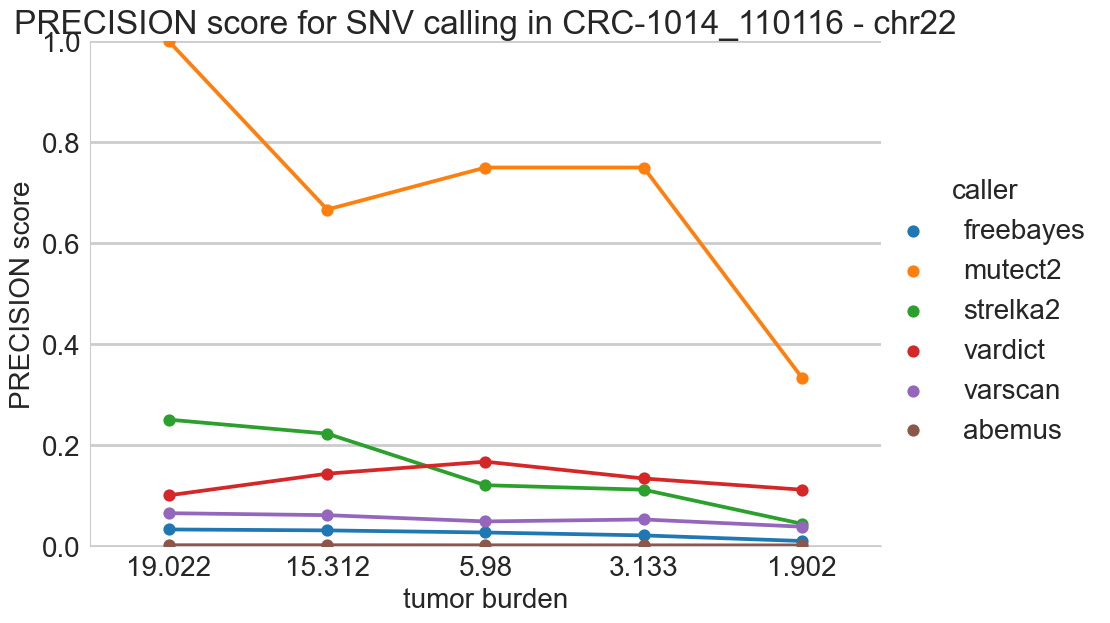

In [63]:
results_auprc_df = metric_curve(config, df_table, plasmasample2, healthysample, dilutionseries, metric='precision', ground_truth_method=3, refsample='undiluted', muttype='SNV', chrom='22', methods=config.methods, save=False)

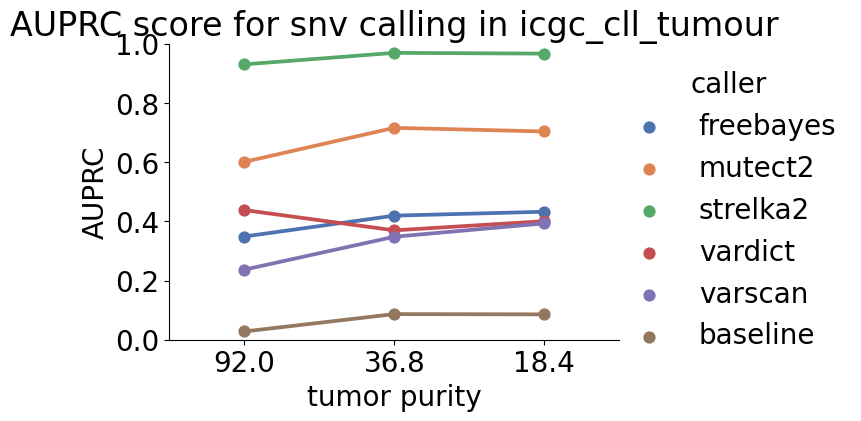

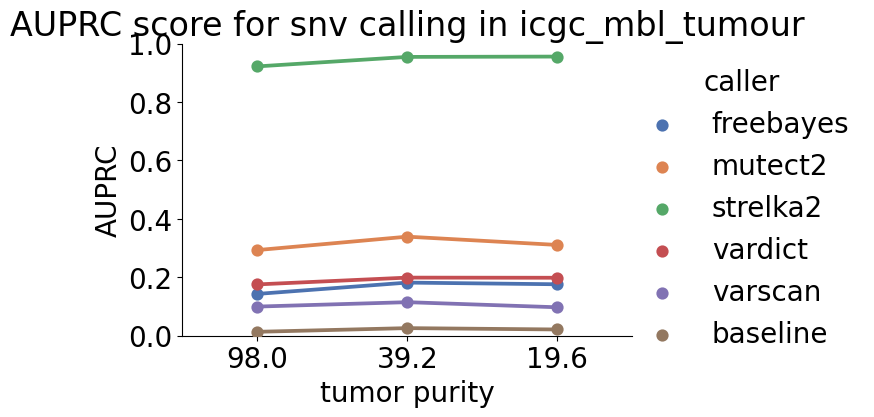

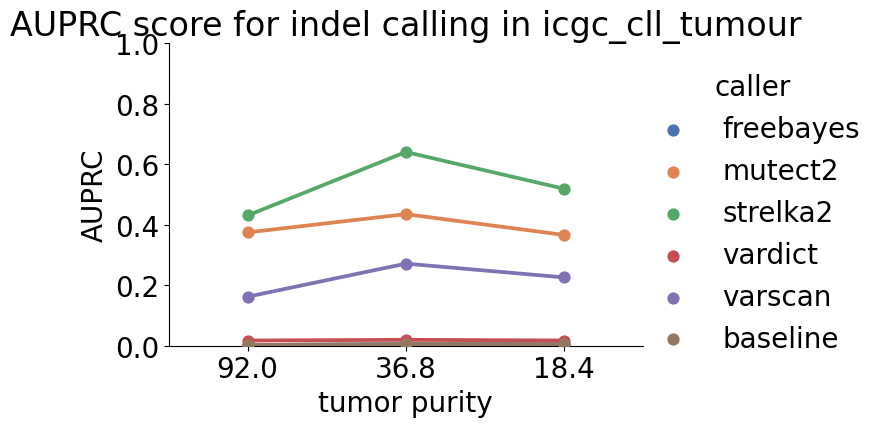

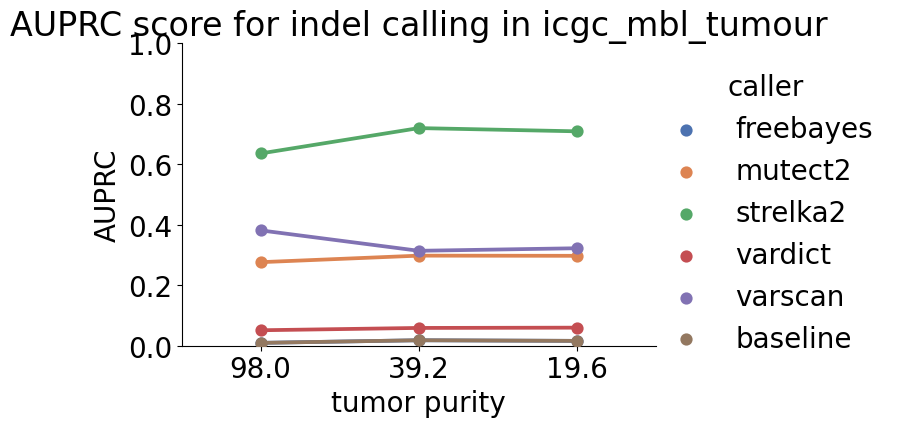

In [5]:
for muttype in config.muttype:
    results_df = pd.DataFrame()
    aux_auprc = []
    aux_method = []
    aux_sample = []
    aux_tp = []
    aux_baseline = []
    for i, sample in enumerate(config.tissuebenchmark.samples):
        for f in config.tissuebenchmark.fractions:
            for method in config.tissuebenchmark.methods:
                #print(muttype, sample, f, method)
                vcf_sample = df_table[(df_table['sample'] == sample) & (df_table['mutation type'] == muttype) & (df_table['purity'] == round(config.tissuebenchmark.purities[i]*f, 2))]
                df_sample_method = vcf_sample[[method+'_score', 'TRUTH']]
                df_sample_method[method + '_score'].fillna(0, inplace=True)
                precision, recall, thresholds = precision_recall_curve(df_sample_method['TRUTH'], df_sample_method[method + '_score'])
                f1 = f1_score(vcf_sample['TRUTH'], vcf_sample[method])
                estimator_name = method if f == 1 else ''
                auprc = average_precision_score(df_sample_method['TRUTH'], df_sample_method[method+'_score'])
                aux_auprc.append(auprc)
                aux_method.append(method)
                aux_sample.append(sample)
                aux_tp.append(round(100*config.tissuebenchmark.purities[i]*f, 2))
            # baseline
            aux_auprc.append(len(vcf_sample['TRUTH'][vcf_sample['TRUTH']])/len(vcf_sample['TRUTH']))
            aux_method.append('baseline')
            aux_sample.append(sample)
            aux_tp.append(round(100*config.tissuebenchmark.purities[i]*f, 2))
            
    results_df['AUPRC'] = aux_auprc
    results_df['tumor purity'] = aux_tp
    results_df['caller'] = aux_method
    results_df['sample'] = aux_sample
    
    for si, sample in enumerate(config.tissuebenchmark.samples):
        sns.catplot(x="tumor purity", y="AUPRC", hue="caller",
                  capsize=.2, height=4, aspect=1.5, kind="point", colors=config.colors + ['k'],
                    order=sorted(results_df[results_df['sample'] == sample]['tumor purity'].unique(), reverse=True),
                        data=results_df[results_df['sample'] == sample])
        plt.ylim([0, 1])
        plt.title("AUPRC score for {} calling in {}".format(muttype, sample))
        plt.savefig('figures/tissue_benchmark/'+sample+'_'+muttype+'_auprcscore',  bbox_inches='tight')

# Change in prediction with dilution

In [7]:
df_table.head()

,truth,45.45_freebayes,45.45_mutect2,45.45_strelka2,45.45_vardict,45.45_varscan,45.45_freebayes_score,45.45_mutect2_score,45.45_strelka2_score,45.45_vardict_score,...,3.133_freebayes,3.133_mutect2,3.133_strelka2,3.133_vardict,3.133_varscan,3.133_freebayes_score,3.133_mutect2_score,3.133_strelka2_score,3.133_vardict_score,3.133_varscan_score
22_16228500,False,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16228507,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16228527,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16228528,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22_16228531,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df = df_table[df_table['truth'] == True]#[['CHROM_POS', 'sample', 'purity', 'mutation type', 'truth', 'freebayes','mutect2', 'strelka2', 'vardict', 'varscan']] # .purity.unstack().add_prefix('purity_')#.groupby('CHROM_POS').sum()
df.unstack

<bound method DataFrame.unstack of             truth 45.45_freebayes 45.45_mutect2 45.45_strelka2 45.45_vardict  \
22_17142499  True            True          True           True          True   
22_17142566  True            True           NaN           True          True   
22_17367749  True            True          True            NaN           NaN   
22_18013228  True            True          True           True          True   
22_20339463  True            True          True            NaN          True   
22_24006229  True            True           NaN           True          True   
22_24006236  True            True           NaN           True          True   
22_24006241  True            True           NaN           True          True   
22_25031040  True            True           NaN           True          True   
22_26479367  True            True          True           True          True   
22_27382820  True            True          True           True          True   
22_27

In [ ]:

fig, ax = plt.subplots(figsize=(15,8))
for m, method in enumerate(config.methods):
    change_df_aux = df_table[(df_table['truth']) & (df_table[method])][['CHROM_POS', 'TRUTH', 'purity'] + [method]].set_index(['CHROM_POS'])
    change_df = pd.DataFrame(index=change_df_aux.index.unique(), columns= ['TRUTH'] + [str(round(config.tissuebenchmark.purities[i]*f, 2)) for f in config.tissuebenchmark.fractions])
    for chrpos in change_df.index:
        for f in config.tissuebenchmark.fractions:
            try:
                change_df.loc[chrpos][str(round(config.tissuebenchmark.purities[i]*f, 2))] = change_df_aux[(change_df_aux['purity'] == round(config.tissuebenchmark.purities[i]*f, 2))].loc[chrpos][method]
            except:
                change_df.loc[chrpos][str(round(config.tissuebenchmark.purities[i]*f, 2))] = False
        if change_df_aux.loc[chrpos]['TRUTH'].shape == ():
            change_df.loc[chrpos]['TRUTH'] = change_df_aux.loc[chrpos]['TRUTH']
        else:
            change_df.loc[chrpos]['TRUTH'] = np.unique(change_df_aux.loc[chrpos]['TRUTH'].values)[0]
    # print(change_df.shape)
    change_df['sum'] = sum([change_df[str(round(config.tissuebenchmark.purities[i]*f, 2))] for f in config.tissuebenchmark.fractions])
    change_df = change_df[~change_df['sum'].isin([0, 3])].dropna(how='all')
    change_df = change_df.astype(int).drop('sum', axis=1)
    # plot
    #for chrpos, row in change_df.astype(int).drop('sum', axis=1).iterrows():
    #    plt.plot(row.astype(int), label=chrpos)
    #plt.legend()
    change_df = change_df.groupby(change_df.columns.tolist(),as_index=False).size()
    print(method)
    print(change_df)

    c = 0.7
    for idx, row in change_df.iterrows():
        plt.plot(row[['TRUTH'] + [str(round(config.tissuebenchmark.purities[i]*f, 2)) for f in config.tissuebenchmark.fractions]], lw=row['size'], label=method, c=config.colors[m], alpha=c-max(1/row['size'], 0.2))
custom_lines = [Line2D([0], [0], color=config.colors[m], lw=2) for m in range(len(config.methods))]
plt.legend(custom_lines, config.methods)

plt.xlabel('purity')
plt.ylabel('mutation calling output prediction')
plt.title('Change in mutation prediction w.r.t purity in {} for {}'.format(sample, muttype))

ax.set_yticks([0,1])
ax.set_yticklabels(['False','True'])
plt.show()

freebayes
   TRUTH  0.92  0.37  0.18  size
0      1     1     0     0    16
1      1     1     0     1     8
mutect2
   TRUTH  0.92  0.37  0.18  size
0      1     0     1     0     2
1      1     1     0     0    18
2      1     1     0     1     9
3      1     1     1     0     9
strelka2
   TRUTH  0.92  0.37  0.18  size
0      1     0     0     1     1
1      1     1     0     0     7
2      1     1     0     1     6
vardict
   TRUTH  0.92  0.37  0.18  size
0      1     0     1     1     1
1      1     1     0     0    27
2      1     1     0     1     4
varscan
   TRUTH  0.92  0.37  0.18  size
0      1     0     1     1     1
1      1     1     0     0    19
2      1     1     0     1     7


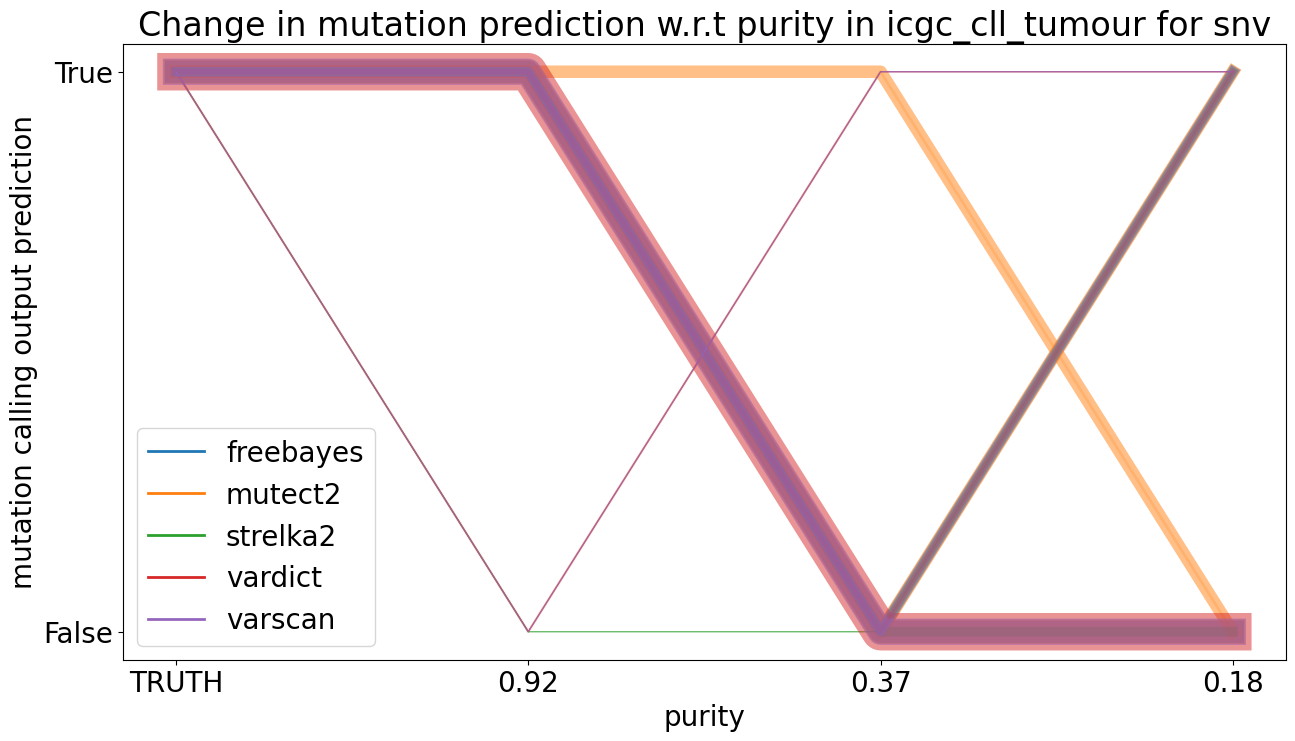

freebayes
   TRUTH  0.92  0.37  0.18  size
0      1     1     0     0     2
mutect2
   TRUTH  0.92  0.37  0.18  size
0      1     1     0     1     1
strelka2
   TRUTH  0.92  0.37  0.18  size
0      1     1     0     0     3
1      1     1     0     1     1
vardict
   TRUTH  0.92  0.37  0.18  size
0      1     1     0     0     4
varscan
   TRUTH  0.92  0.37  0.18  size
0      1     1     0     0     1
1      1     1     0     1     2


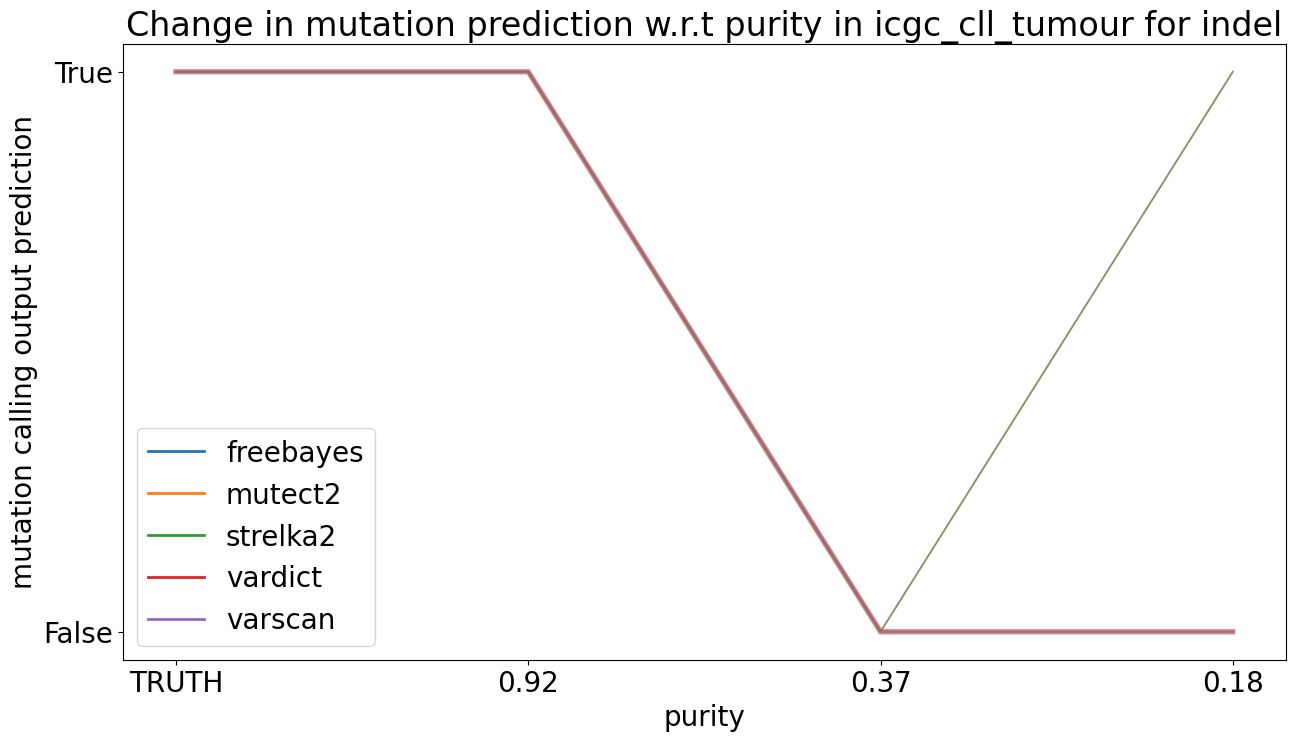

freebayes
   TRUTH  0.98  0.39  0.2  size
0      1     1     0    0    15
1      1     1     0    1     5
mutect2
   TRUTH  0.98  0.39  0.2  size
0      1     1     0    0     5
1      1     1     0    1     6
strelka2
   TRUTH  0.98  0.39  0.2  size
0      1     1     0    0     1
1      1     1     0    1     4
vardict
   TRUTH  0.98  0.39  0.2  size
0      1     1     0    0    16
1      1     1     0    1     7
varscan
   TRUTH  0.98  0.39  0.2  size
0      1     1     0    0    17
1      1     1     0    1     5


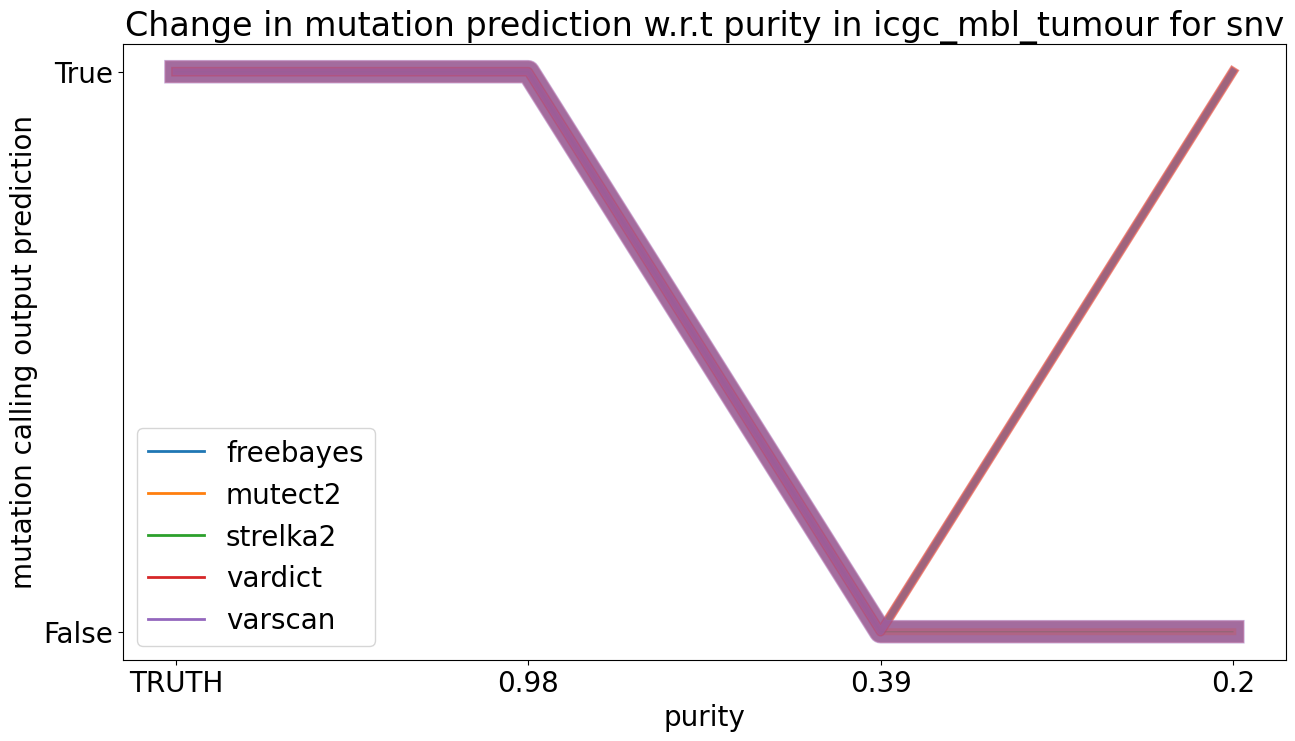

freebayes
   TRUTH  0.98  0.39  0.2  size
0      1     1     0    0     2
mutect2
   TRUTH  0.98  0.39  0.2  size
0      1     1     0    0     7
1      1     1     0    1     5
strelka2
   TRUTH  0.98  0.39  0.2  size
0      1     1     0    0     3
1      1     1     0    1     1
vardict
   TRUTH  0.98  0.39  0.2  size
0      1     1     0    0     3
varscan
   TRUTH  0.98  0.39  0.2  size
0      1     1     0    0     2
1      1     1     0    1     2


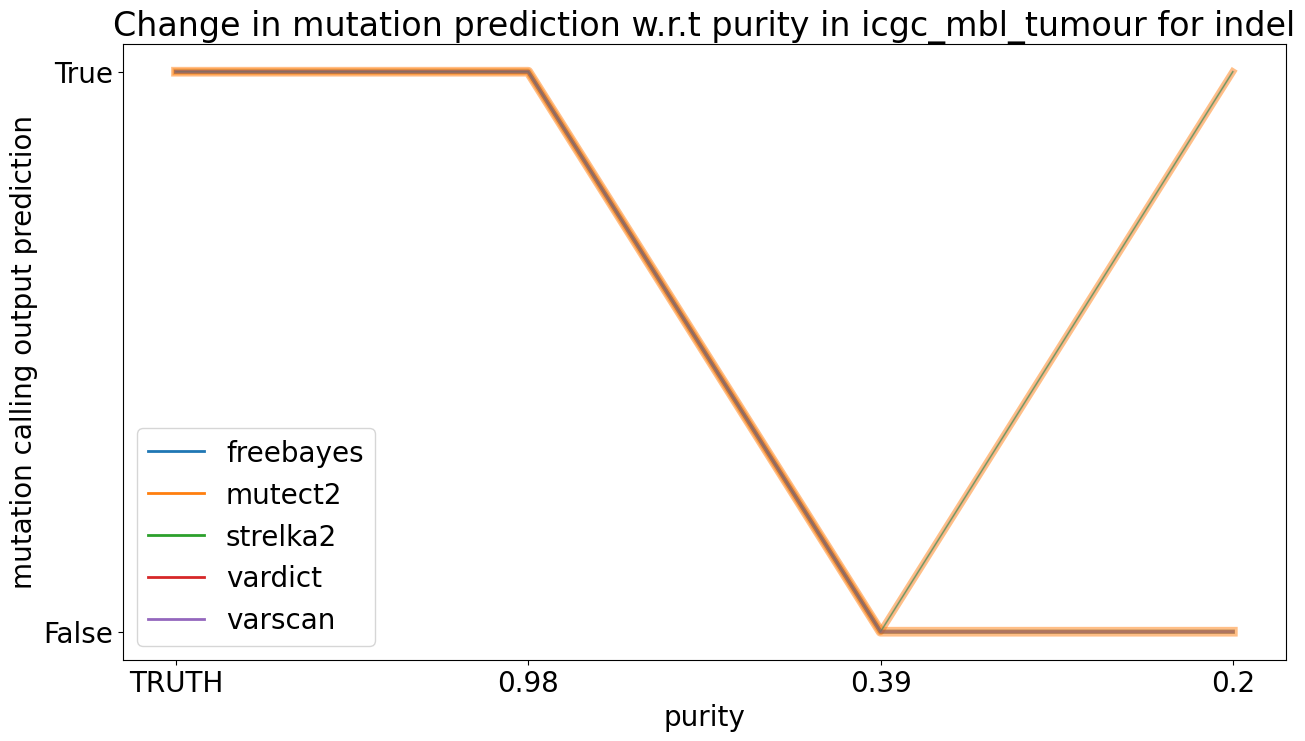

In [9]:
for i, sample in enumerate(config.tissuebenchmark.samples):
    for muttype in config.muttype:
        fig, ax = plt.subplots(figsize=(15,8))
        for m, method in enumerate(config.methods):
            change_df_aux = df_table[(df_table['sample'] == sample) & (df_table['mutation type'] == muttype) & (df_table['TRUTH']) & (df_table[method])][['CHROM_POS', 'TRUTH', 'purity'] + [method]].set_index(['CHROM_POS'])
            change_df = pd.DataFrame(index=change_df_aux.index.unique(), columns= ['TRUTH'] + [str(round(config.tissuebenchmark.purities[i]*f, 2)) for f in config.tissuebenchmark.fractions])
            for chrpos in change_df.index:
                for f in config.tissuebenchmark.fractions:
                    try:
                        change_df.loc[chrpos][str(round(config.tissuebenchmark.purities[i]*f, 2))] = change_df_aux[(change_df_aux['purity'] == round(config.tissuebenchmark.purities[i]*f, 2))].loc[chrpos][method]
                    except:
                        change_df.loc[chrpos][str(round(config.tissuebenchmark.purities[i]*f, 2))] = False
                if change_df_aux.loc[chrpos]['TRUTH'].shape == ():
                    change_df.loc[chrpos]['TRUTH'] = change_df_aux.loc[chrpos]['TRUTH']
                else:
                    change_df.loc[chrpos]['TRUTH'] = np.unique(change_df_aux.loc[chrpos]['TRUTH'].values)[0]
            # print(change_df.shape)
            change_df['sum'] = sum([change_df[str(round(config.tissuebenchmark.purities[i]*f, 2))] for f in config.tissuebenchmark.fractions])
            change_df = change_df[~change_df['sum'].isin([0, 3])].dropna(how='all')
            change_df = change_df.astype(int).drop('sum', axis=1)
            # plot
            #for chrpos, row in change_df.astype(int).drop('sum', axis=1).iterrows():
            #    plt.plot(row.astype(int), label=chrpos)
            #plt.legend()
            change_df = change_df.groupby(change_df.columns.tolist(),as_index=False).size()
            print(method)
            print(change_df)

            c = 0.7
            for idx, row in change_df.iterrows():
                plt.plot(row[['TRUTH'] + [str(round(config.tissuebenchmark.purities[i]*f, 2)) for f in config.tissuebenchmark.fractions]], lw=row['size'], label=method, c=config.colors[m], alpha=c-max(1/row['size'], 0.2))
        custom_lines = [Line2D([0], [0], color=config.colors[m], lw=2) for m in range(len(config.methods))]
        plt.legend(custom_lines, config.methods)

        plt.xlabel('purity')
        plt.ylabel('mutation calling output prediction')
        plt.title('Change in mutation prediction w.r.t purity in {} for {}'.format(sample, muttype))

        ax.set_yticks([0,1])
        ax.set_yticklabels(['False','True'])
        plt.show()

# True Positive, False Negative and False Positive Mutations

In [10]:
df = pd.DataFrame(columns=['sample', 'mutation type', 'caller', 'purity', 'metric', 'number of loci', 'rate',  'number of mutations (ground truth)']) #'TN', 'FP', 'FN', 'TP'])
metric = ['TN', 'FP', 'FN', 'TP']
c = 0
for muttype in config.muttype:
    for i, sample in enumerate(config.tissuebenchmark.samples):
        for method in config.tissuebenchmark.methods:
            print(muttype, sample, method)
            for f in config.tissuebenchmark.fractions:
                vcf_sample = df_table[(df_table['sample'] == sample) & (df_table['mutation type'] == muttype) & (df_table['purity'] == round(config.tissuebenchmark.purities[i]*f, 2))]
                ntruth = sum(vcf_sample['TRUTH'])
                tn, fp, fn, tp = confusion_matrix(vcf_sample['TRUTH'], vcf_sample[method], labels=[0,1]).ravel()
                tpfn = tp + fn
                tnfp = tn + fp
                for j, tfpn in enumerate([tn, fp, fn, tp]):
                    # df.loc[c, :] = [sample, muttype, method, round(config.tissuebenchmark.purities[i]*f, 2), tn, fp, fn, tp]
                    if j in [0, 1]:
                        df.loc[c, :] = [sample, muttype, method, round(config.tissuebenchmark.purities[i]*f, 2), metric[c%4], tfpn, tfpn/tnfp, ntruth]
                    else: # j in [2,3]
                        df.loc[c, :] = [sample, muttype, method, round(config.tissuebenchmark.purities[i]*f, 2), metric[c%4], tfpn, tfpn/tpfn, ntruth]
                    c += 1
df.head(20)

snv icgc_cll_tumour freebayes
snv icgc_cll_tumour mutect2
snv icgc_cll_tumour strelka2
snv icgc_cll_tumour vardict
snv icgc_cll_tumour varscan
snv icgc_mbl_tumour freebayes
snv icgc_mbl_tumour mutect2
snv icgc_mbl_tumour strelka2
snv icgc_mbl_tumour vardict
snv icgc_mbl_tumour varscan
indel icgc_cll_tumour freebayes
indel icgc_cll_tumour mutect2
indel icgc_cll_tumour strelka2
indel icgc_cll_tumour vardict
indel icgc_cll_tumour varscan
indel icgc_mbl_tumour freebayes
indel icgc_mbl_tumour mutect2
indel icgc_mbl_tumour strelka2
indel icgc_mbl_tumour vardict
indel icgc_mbl_tumour varscan


,sample,mutation type,caller,purity,metric,number of loci,rate,number of mutations (ground truth)
0,icgc_cll_tumour,snv,freebayes,0.92,TN,8344,0.902152,265
1,icgc_cll_tumour,snv,freebayes,0.92,FP,905,0.0978484,265
2,icgc_cll_tumour,snv,freebayes,0.92,FN,34,0.128302,265
3,icgc_cll_tumour,snv,freebayes,0.92,TP,231,0.871698,265
4,icgc_cll_tumour,snv,freebayes,0.37,TN,2513,0.926964,257
5,icgc_cll_tumour,snv,freebayes,0.37,FP,198,0.0730358,257
6,icgc_cll_tumour,snv,freebayes,0.37,FN,50,0.194553,257
7,icgc_cll_tumour,snv,freebayes,0.37,TP,207,0.805447,257
8,icgc_cll_tumour,snv,freebayes,0.18,TN,2522,0.913106,259
9,icgc_cll_tumour,snv,freebayes,0.18,FP,240,0.0868936,259


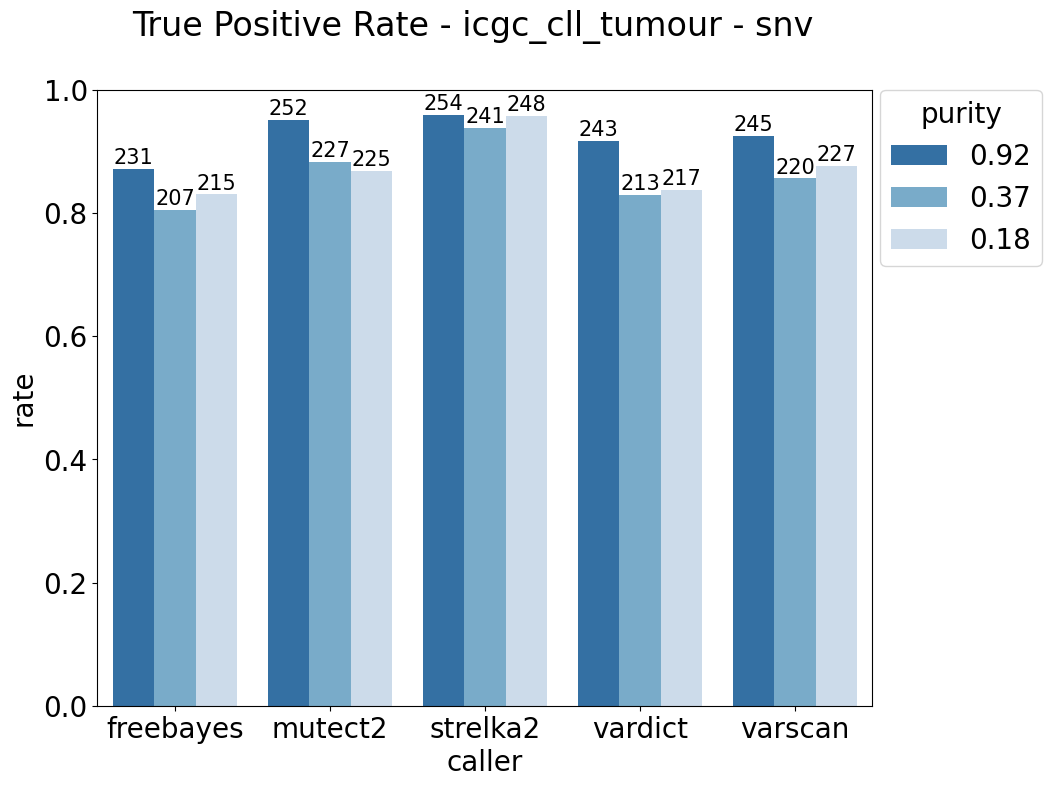

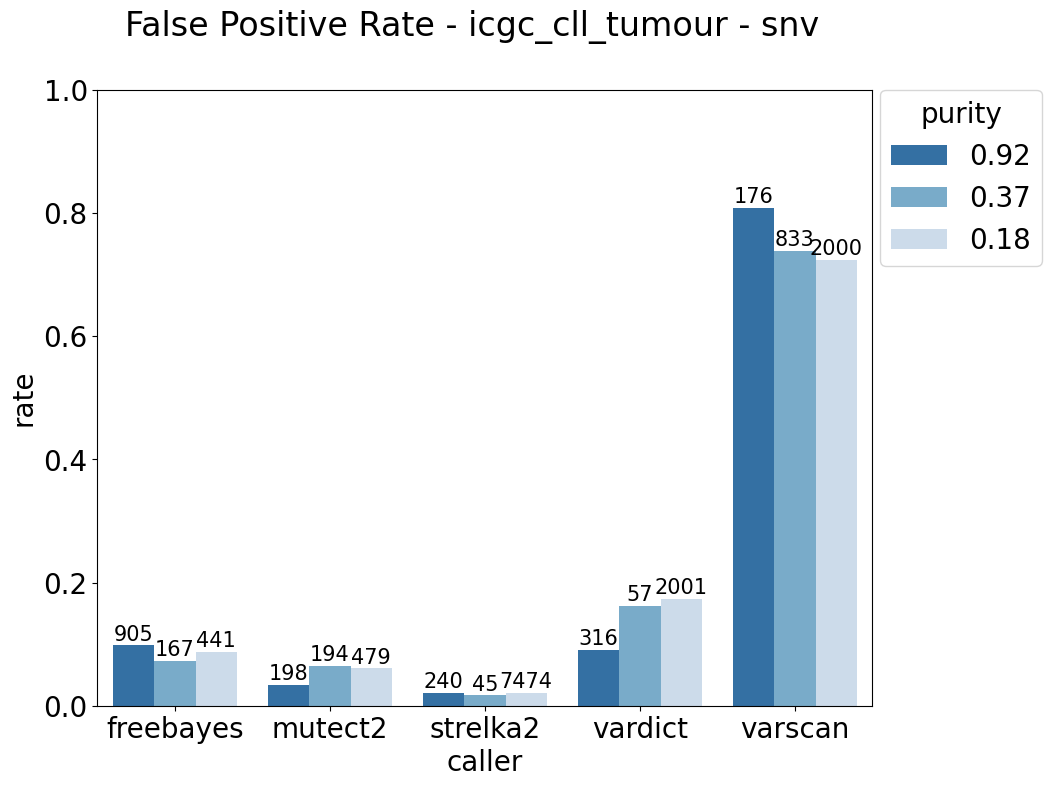

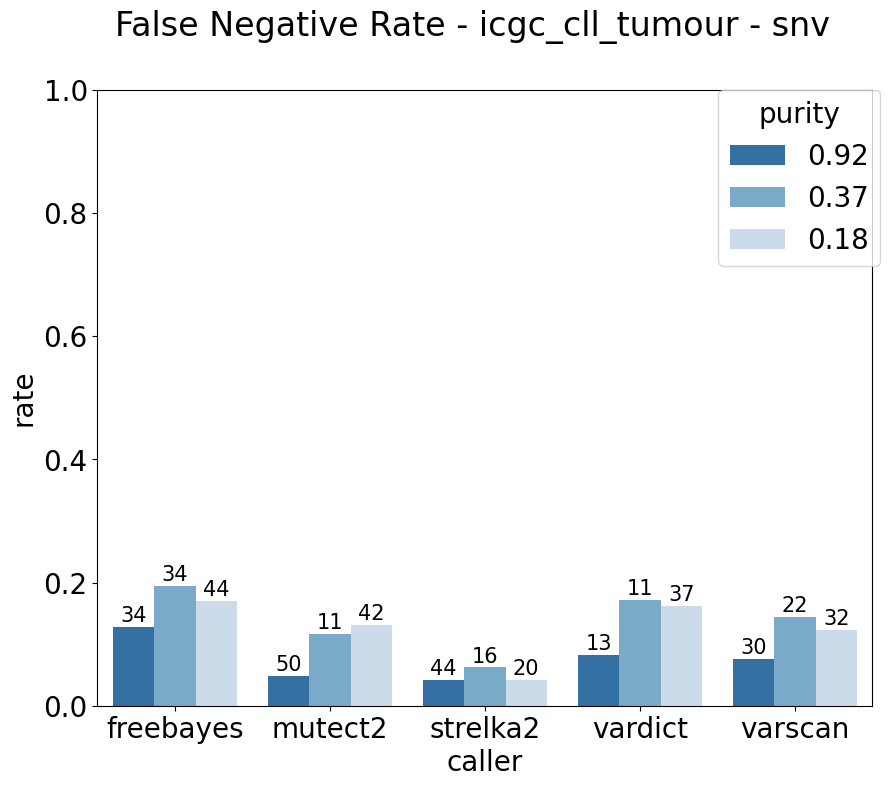

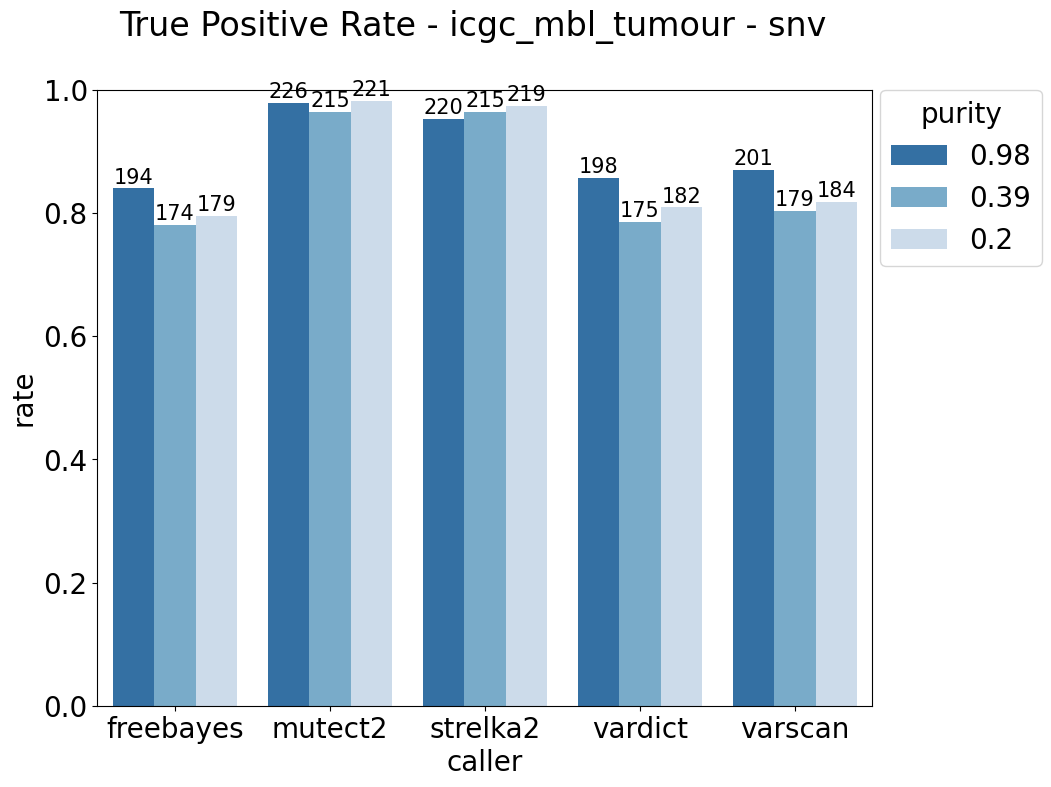

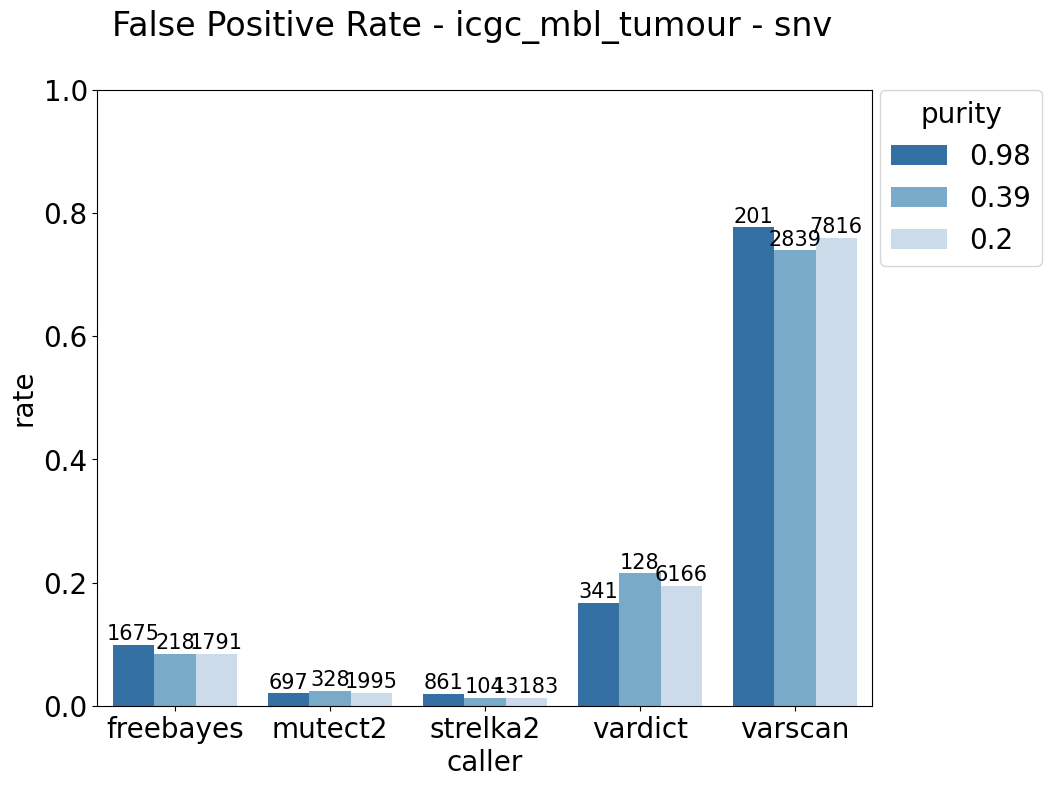

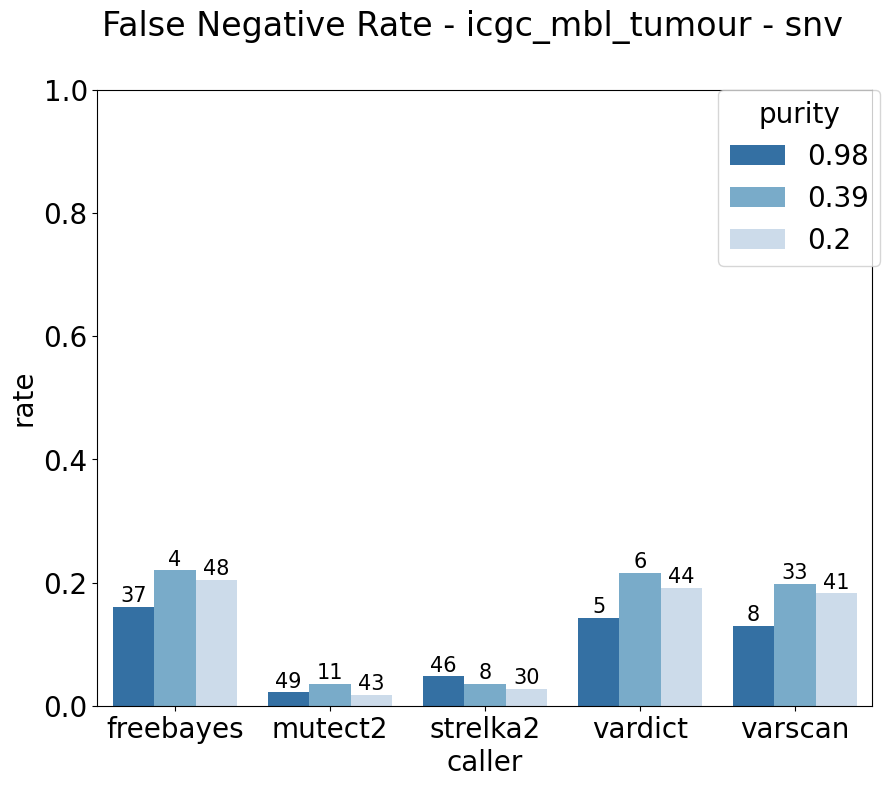

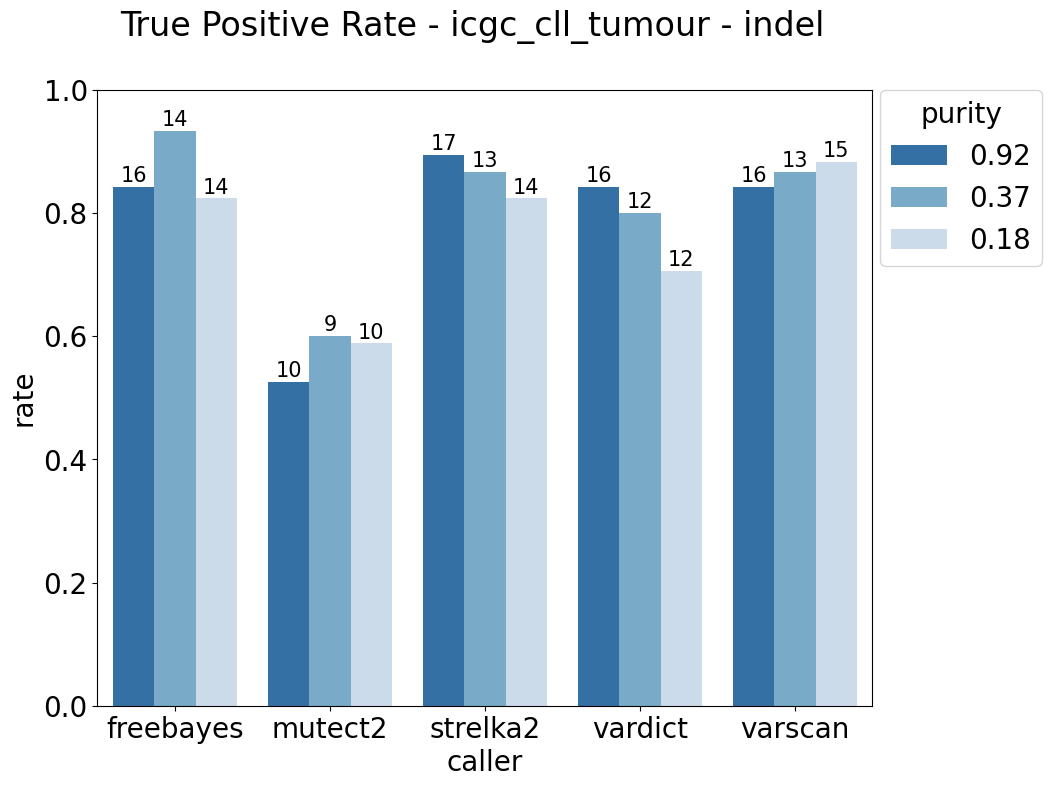

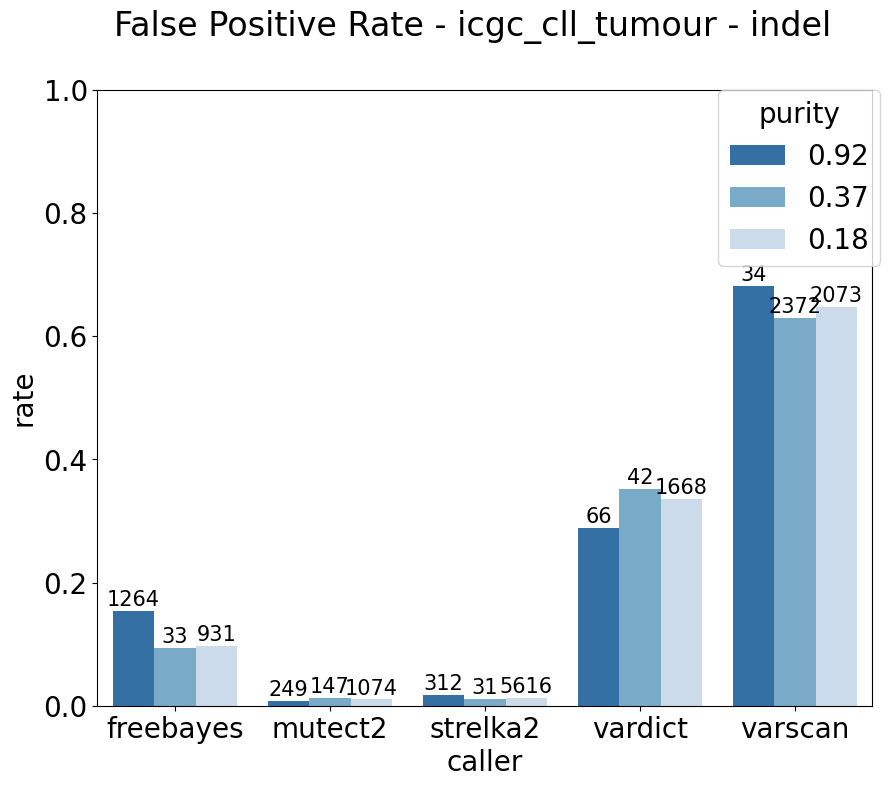

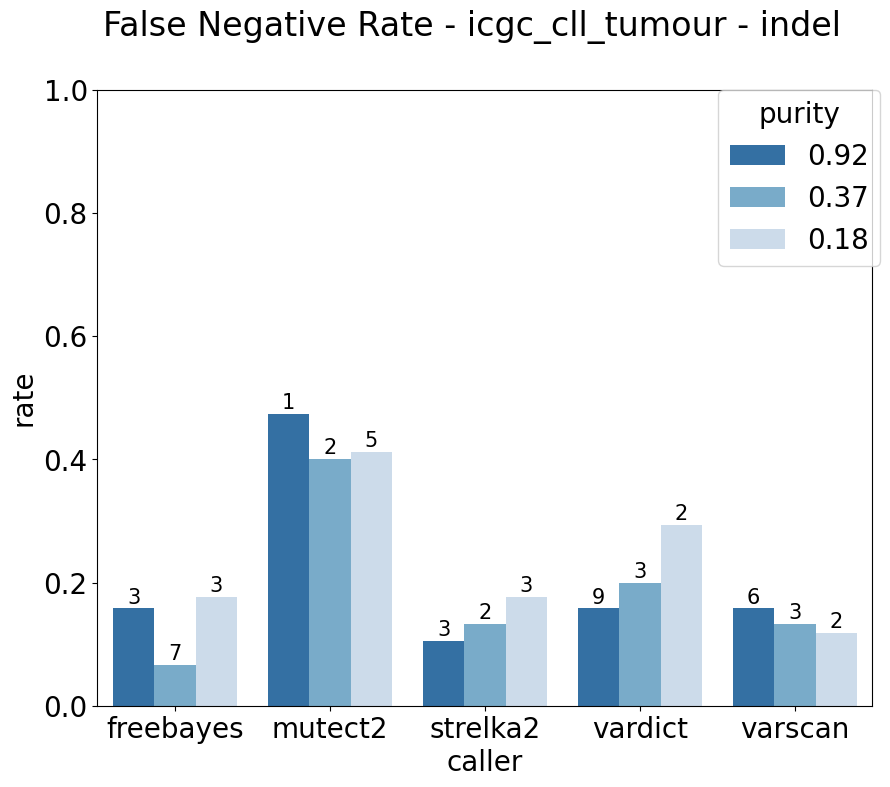

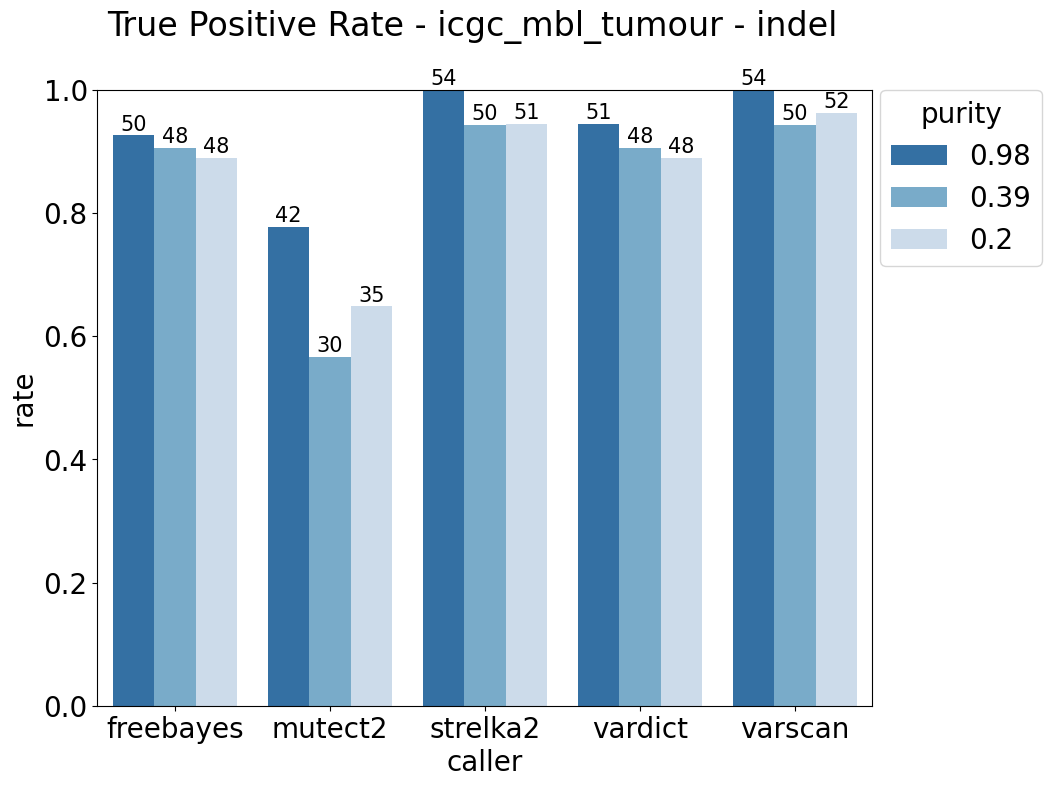

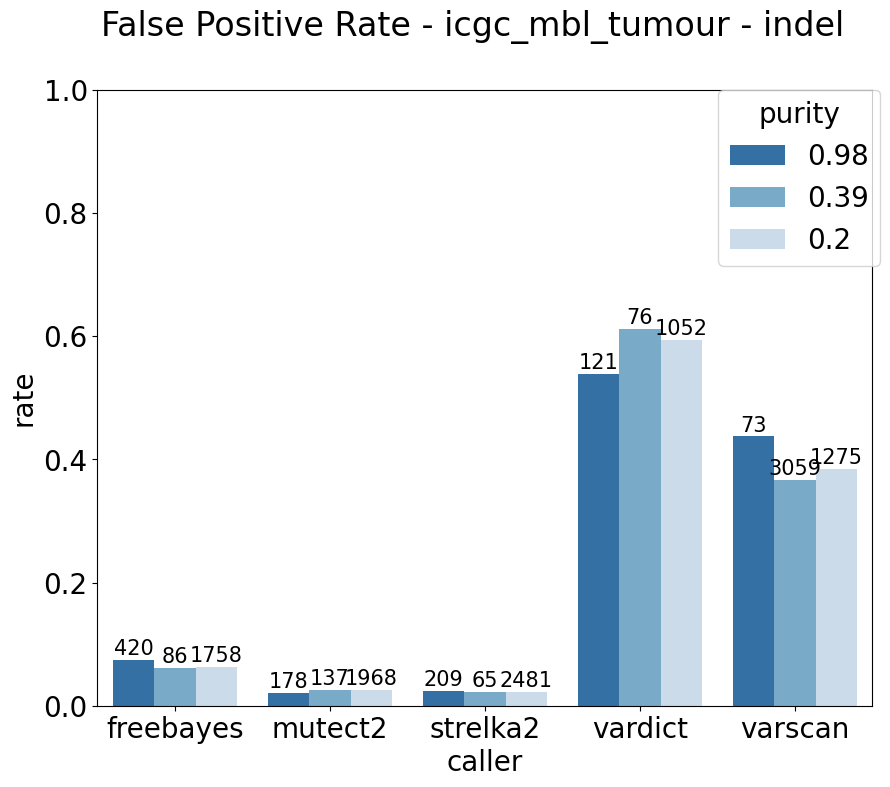

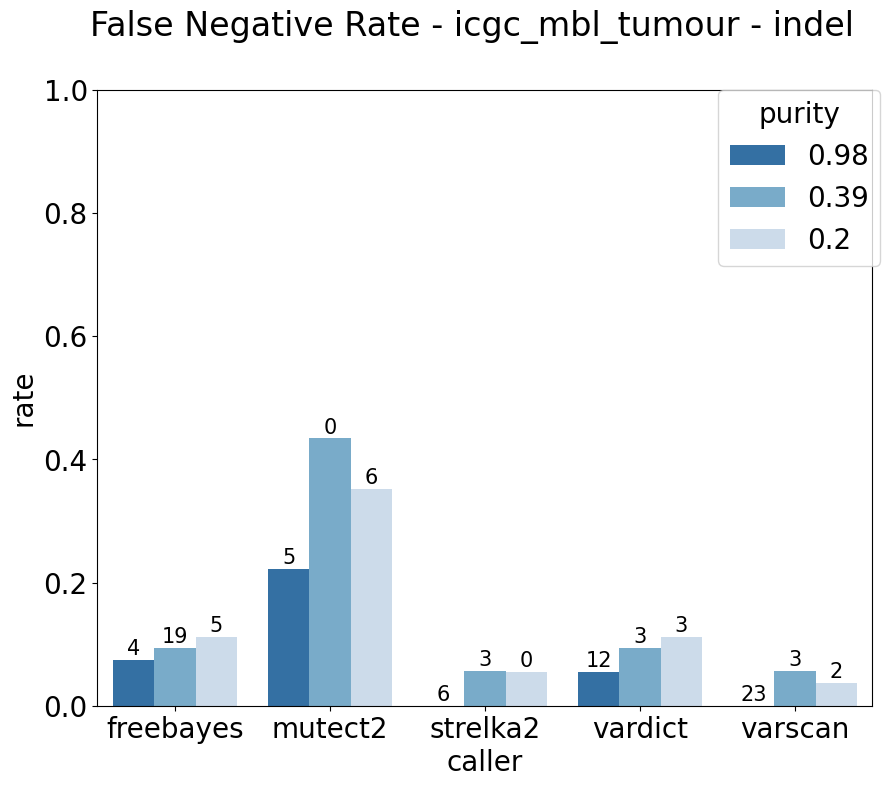

In [11]:
for muttype in config.muttype:
    for s, sample in enumerate(config.tissuebenchmark.samples):
        plt.figure(figsize=(10,8))
        plots = sns.barplot(x="caller", y="rate", hue="purity", data=df[(df['sample'] == sample) & (df['mutation type'] == muttype) & (df['metric'] == 'TP')], ci=None, palette='Blues_r',
                            hue_order=[round(config.tissuebenchmark.purities[s]*config.tissuebenchmark.fractions[i], 2) for i in range(3)])
        plt.suptitle('True Positive Rate - '+sample+ ' - '+muttype)
        plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, title='purity')
        plt.ylim([0,1])
        xcoords, ycoords = [], []
        ci = 0
        # Iterrating over the bars one-by-one
        for b, bar in enumerate(plots.patches):
            plots.annotate(df[(df['sample'] == sample) & (df['mutation type'] == muttype) & (df['metric'] == 'TP') & (df['caller'] == config.methods[b%5]) & (df['purity'] == round(config.tissuebenchmark.purities[s]*config.tissuebenchmark.fractions[b//5], 2))]['number of loci'].values[0],
                   (bar.get_x() + (bar.get_width() / 2),
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
            
        for m,methods in enumerate(config.methods):
            for b, bar in enumerate(plots.patches):
                if b % len(config.methods) == m:
                    #print(b)
                    if len(xcoords) == 3:
                        xcoords, ycoords = [], []
                    xi = bar.get_x() + (bar.get_width() / 2)
                    yi = df[(df['sample'] == sample) & (df['mutation type'] == muttype) & (df['caller'] == config.methods[b//3]) & (df['purity'] == round(config.tissuebenchmark.purities[s]*config.tissuebenchmark.fractions[b%3], 2))]['number of mutations (ground truth)'].values[0]
                    xcoords.append(xi)
                    ycoords.append(yi)
                    if len(xcoords) == 3:
                        if m == 0:
                            redline = ax.plot(xcoords, ycoords, 'ro-', label='Number of ground truths mutations')
                        else:
                            ax.plot(xcoords, ycoords, 'ro-')
        plt.savefig('figures/tissue_benchmark/'+sample+'_'+muttype+'_TPrate',  bbox_inches='tight')

        
        plt.figure(figsize=(10,8))
        plots = sns.barplot(x="caller", y="rate", hue="purity", data=df[(df['sample'] == sample) & (df['mutation type'] == muttype) & (df['metric'] == 'FP')], ci=None, palette='Blues_r',
                            hue_order=[round(config.tissuebenchmark.purities[s]*config.tissuebenchmark.fractions[i], 2) for i in range(3)])
        plt.suptitle('False Positive Rate - '+sample+ ' - '+muttype)
        plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, title='purity')
        plt.ylim([0,1])
        # Iterrating over the bars one-by-one
        for b, bar in enumerate(plots.patches):
            plots.annotate(df[(df['sample'] == sample) & (df['mutation type'] == muttype) & (df['metric'] == 'FP') & (df['caller'] == config.methods[b//3]) & (df['purity'] == round(config.tissuebenchmark.purities[s]*config.tissuebenchmark.fractions[b%3], 2))]['number of loci'].values[0],
                            #format(bar.get_height(), '.2f'),
                           (bar.get_x() + bar.get_width() / 2,
                            bar.get_height()), ha='center', va='center',
                           size=15, xytext=(0, 8),
                           textcoords='offset points')
        plt.savefig('figures/tissue_benchmark/'+sample+'_'+muttype+'_FPrate',  bbox_inches='tight')

            
        plt.figure(figsize=(10,8))
        plots = sns.barplot(x="caller", y="rate", hue="purity", data=df[(df['sample'] == sample) & (df['mutation type'] == muttype) & (df['metric'] == 'FN')], ci=None, palette='Blues_r',
                            hue_order=[round(config.tissuebenchmark.purities[s]*config.tissuebenchmark.fractions[i], 2) for i in range(3)])
        plt.suptitle('False Negative Rate - '+sample+ ' - '+muttype)
        plt.legend(bbox_to_anchor=(1.01, 1),  borderaxespad=0, title='purity')
        plt.ylim([0,1])
        # Iterrating over the bars one-by-one
        for b, bar in enumerate(plots.patches):
            plots.annotate(df[(df['sample'] == sample) & (df['mutation type'] == muttype) & (df['metric'] == 'FN') & (df['caller'] == config.methods[b//3]) & (df['purity'] == round(config.tissuebenchmark.purities[s]*config.tissuebenchmark.fractions[b%3], 2))]['number of loci'].values[0],
                            #format(bar.get_height(), '.2f'),
                           (bar.get_x() + bar.get_width() / 2,
                            bar.get_height()), ha='center', va='center',
                           size=15, xytext=(0, 8),
                           textcoords='offset points')
        plt.savefig('figures/tissue_benchmark/'+sample+'_'+muttype+'_FNrate',  bbox_inches='tight')


# Stacked TP, FN, FP, TN

In [12]:
df = pd.DataFrame(columns=['sample', 'mutation type', 'caller', 'purity', 'TP', 'FN', 'FP', 'FN', ])
metric = ['TN', 'FP', 'FN', 'TP']
c = 0
for muttype in config.muttype:
    for i, sample in enumerate(config.tissuebenchmark.samples):
        for method in config.tissuebenchmark.methods:
            print(muttype, sample, method)
            for f in config.tissuebenchmark.fractions:
                vcf_sample = df_table[(df_table['sample'] == sample) & (df_table['mutation type'] == muttype) & (df_table['purity'] == round(config.tissuebenchmark.purities[i]*f, 2))]
                tn, fp, fn, tp = confusion_matrix(vcf_sample['TRUTH'], vcf_sample[method], labels=[0,1]).ravel()
                tpfn = tp + fn
                tnfp = tn + fp
                df.loc[c, :] = [sample, muttype, method, round(config.tissuebenchmark.purities[i]*f, 2), tp, fn, fp, tn]
                c += 1
df.head()

snv icgc_cll_tumour freebayes
snv icgc_cll_tumour mutect2
snv icgc_cll_tumour strelka2
snv icgc_cll_tumour vardict
snv icgc_cll_tumour varscan
snv icgc_mbl_tumour freebayes
snv icgc_mbl_tumour mutect2
snv icgc_mbl_tumour strelka2
snv icgc_mbl_tumour vardict
snv icgc_mbl_tumour varscan
indel icgc_cll_tumour freebayes
indel icgc_cll_tumour mutect2
indel icgc_cll_tumour strelka2
indel icgc_cll_tumour vardict
indel icgc_cll_tumour varscan
indel icgc_mbl_tumour freebayes
indel icgc_mbl_tumour mutect2
indel icgc_mbl_tumour strelka2
indel icgc_mbl_tumour vardict
indel icgc_mbl_tumour varscan


,sample,mutation type,caller,purity,TP,FN,FP,FN
0,icgc_cll_tumour,snv,freebayes,0.92,231,34,905,8344
1,icgc_cll_tumour,snv,freebayes,0.37,207,50,198,2513
2,icgc_cll_tumour,snv,freebayes,0.18,215,44,240,2522
3,icgc_cll_tumour,snv,mutect2,0.92,252,13,316,8933
4,icgc_cll_tumour,snv,mutect2,0.37,227,30,176,2535


In [13]:
df = pd.DataFrame(columns=['sample', 'mutation type', 'caller', 'purity',  'caller_purity',  'metric', 'number of loci', 'rate']) #'TN', 'FP', 'FN', 'TP'])
metric = ['TN', 'FP', 'FN', 'TP']
c = 0
d = 0
for muttype in config.muttype:
    for i, sample in enumerate(config.tissuebenchmark.samples):
        for method in config.tissuebenchmark.methods:
            print(muttype, sample, method)
            for f in config.tissuebenchmark.fractions:
                vcf_sample = df_table[(df_table['sample'] == sample) & (df_table['mutation type'] == muttype) & (df_table['purity'] == round(config.tissuebenchmark.purities[i]*f, 2))]
                tn, fp, fn, tp = confusion_matrix(vcf_sample['TRUTH'], vcf_sample[method], labels=[0,1]).ravel()
                tpfn = tp + fn
                tnfp = tn + fp
                for j, tfpn in enumerate([tn, fp, fn, tp]):
                    # df.loc[c, :] = [sample, muttype, method, round(config.tissuebenchmark.purities[i]*f, 2), tn, fp, fn, tp]
                    if j in [0, 1]:
                        df.loc[c+d, :] = [sample, muttype, method, round(config.tissuebenchmark.purities[i]*f, 2), method + '_' + str(round(config.tissuebenchmark.purities[i]*f, 2)), metric[c%4], tfpn, tfpn/tnfp]
                    else: # j in [2,3]
                        df.loc[c+d, :] = [sample, muttype, method, round(config.tissuebenchmark.purities[i]*f, 2), method + '_' + str(round(config.tissuebenchmark.purities[i]*f, 2)), metric[c%4], tfpn, tfpn/tpfn]
                    c += 1
            
            df.loc[c+d, :] = [sample, muttype, method, 0, method+'_0', 'TN', 0, 0]
            d += 1
df.head(30)

snv icgc_cll_tumour freebayes
snv icgc_cll_tumour mutect2
snv icgc_cll_tumour strelka2
snv icgc_cll_tumour vardict
snv icgc_cll_tumour varscan
snv icgc_mbl_tumour freebayes
snv icgc_mbl_tumour mutect2
snv icgc_mbl_tumour strelka2
snv icgc_mbl_tumour vardict
snv icgc_mbl_tumour varscan
indel icgc_cll_tumour freebayes
indel icgc_cll_tumour mutect2
indel icgc_cll_tumour strelka2
indel icgc_cll_tumour vardict
indel icgc_cll_tumour varscan
indel icgc_mbl_tumour freebayes
indel icgc_mbl_tumour mutect2
indel icgc_mbl_tumour strelka2
indel icgc_mbl_tumour vardict
indel icgc_mbl_tumour varscan


,sample,mutation type,caller,purity,caller_purity,metric,number of loci,rate
0,icgc_cll_tumour,snv,freebayes,0.92,freebayes_0.92,TN,8344,0.902152
1,icgc_cll_tumour,snv,freebayes,0.92,freebayes_0.92,FP,905,0.0978484
2,icgc_cll_tumour,snv,freebayes,0.92,freebayes_0.92,FN,34,0.128302
3,icgc_cll_tumour,snv,freebayes,0.92,freebayes_0.92,TP,231,0.871698
4,icgc_cll_tumour,snv,freebayes,0.37,freebayes_0.37,TN,2513,0.926964
5,icgc_cll_tumour,snv,freebayes,0.37,freebayes_0.37,FP,198,0.0730358
6,icgc_cll_tumour,snv,freebayes,0.37,freebayes_0.37,FN,50,0.194553
7,icgc_cll_tumour,snv,freebayes,0.37,freebayes_0.37,TP,207,0.805447
8,icgc_cll_tumour,snv,freebayes,0.18,freebayes_0.18,TN,2522,0.913106
9,icgc_cll_tumour,snv,freebayes,0.18,freebayes_0.18,FP,240,0.0868936


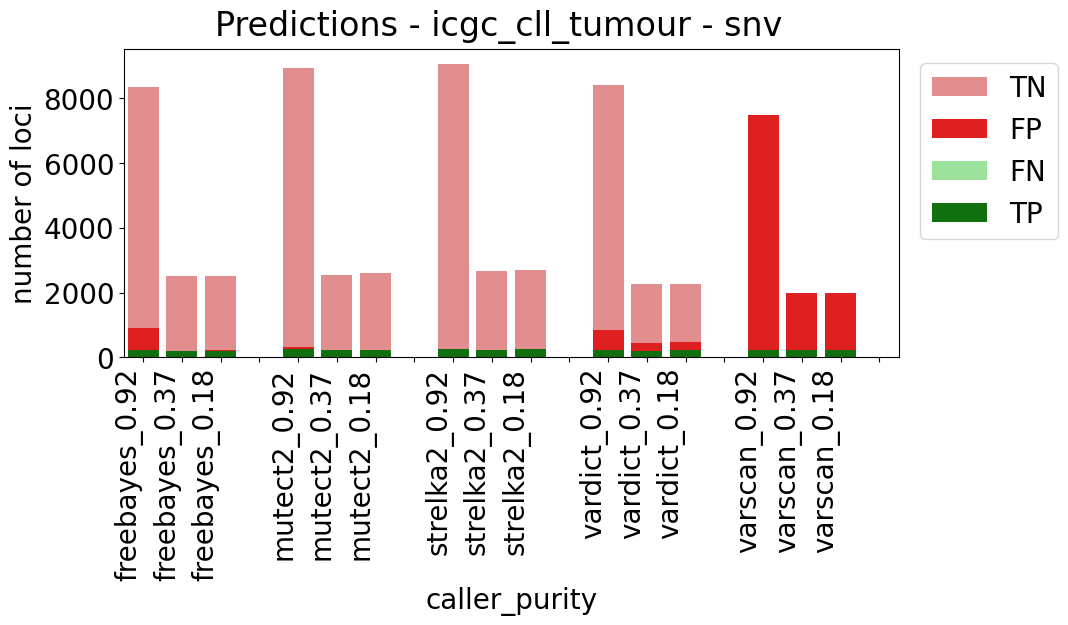

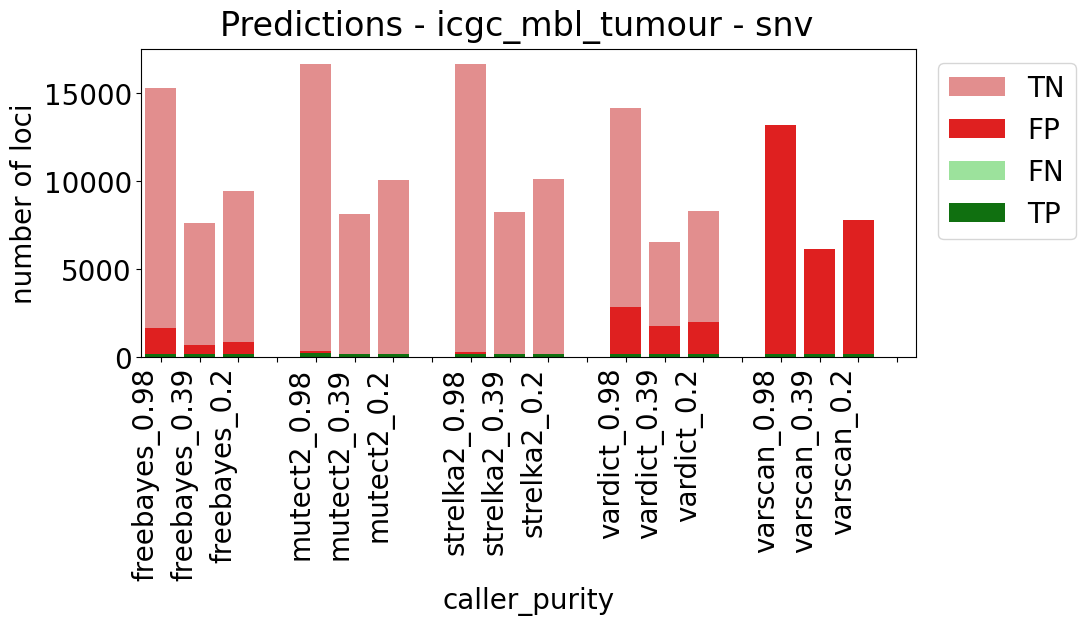

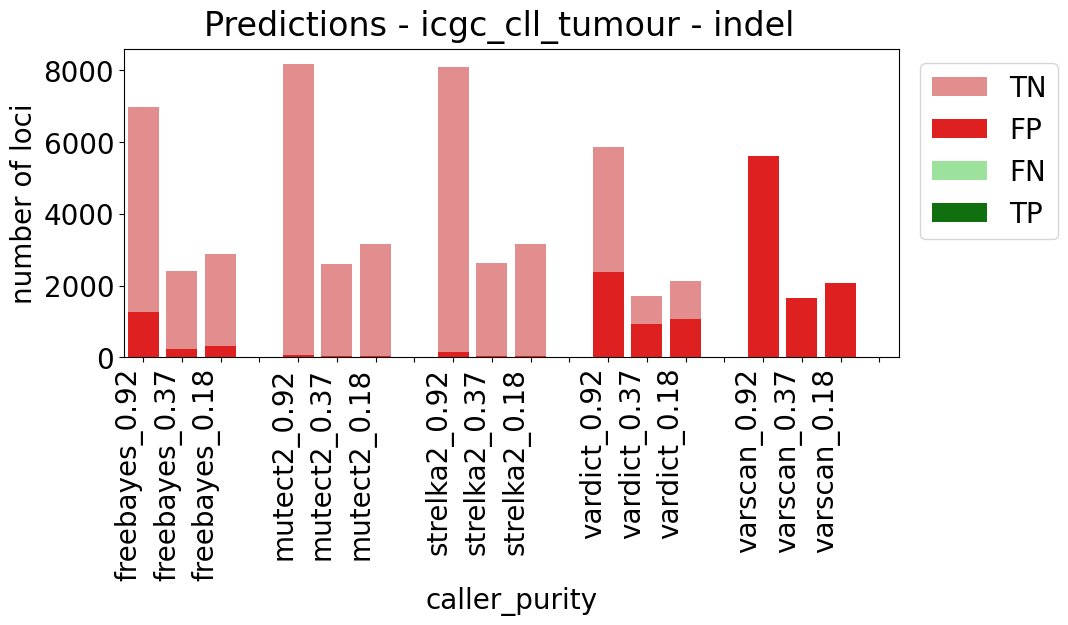

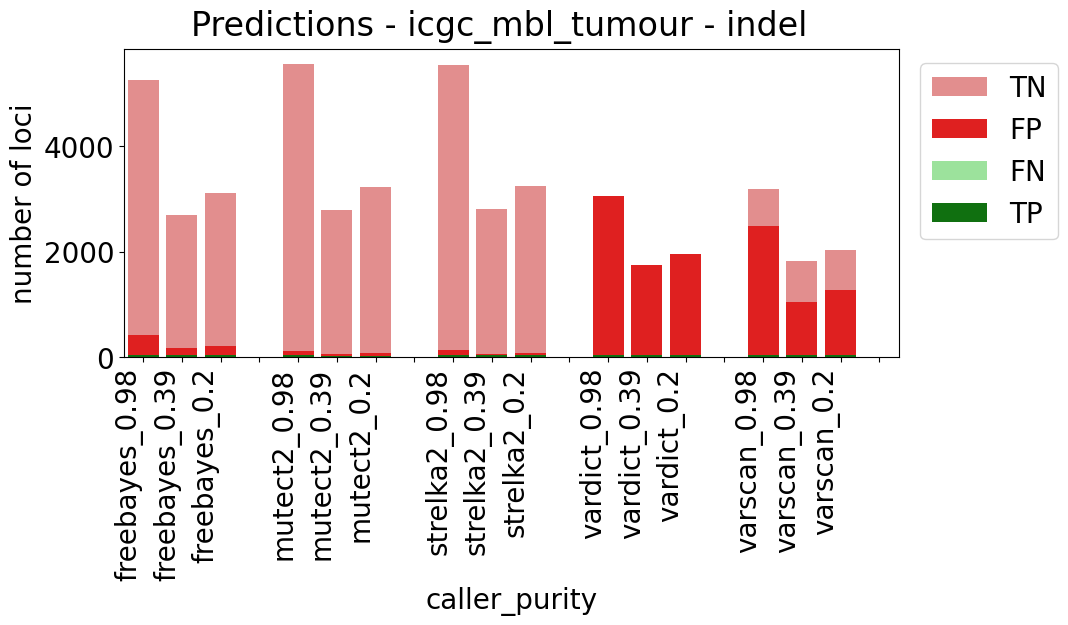

In [14]:
for muttype in config.muttype:
    for s, sample in enumerate(config.tissuebenchmark.samples):
        #for f in config.tissuebenchmark.fractions:
        #for m in config.methods:
        plt.figure(figsize=(10,4))
        bar = sns.barplot(x="caller_purity", y="number of loci", hue="metric", data=df[(df['sample'] == sample) & (df['mutation type'] == muttype)],
                    #order= [round(config.tissuebenchmark.purities[s]*config.tissuebenchmark.fractions[i], 2) for i in range(3)],
                    palette=['lightcoral', 'red', 'lightgreen', 'green'],
                    dodge= False)
        bar.set_xticklabels(bar.get_xticklabels(), rotation=90, horizontalalignment='right')
        labels = bar.get_xticklabels() 
        labels = [l if ((i+1)%4 != 0) else '' for i, l in enumerate(labels)]
        bar.set_xticklabels(labels)
        plt.suptitle('Predictions - '+sample+ ' - '+muttype)
        plt.legend(bbox_to_anchor=(1.01, 1))
        #plt.ylim([0,1])
        plt.savefig('figures/tissue_benchmark/'+sample+'_'+muttype+'_predictions',  bbox_inches='tight')

# Number of mutations

In [15]:
df = pd.DataFrame(columns=['sample', 'mutation type', 'caller', 'purity', 'number of loci called', 'number of mutations (ground truth)']) #'TN', 'FP', 'FN', 'TP'])
metric = ['TN', 'FP', 'FN', 'TP']
c = 0
for muttype in config.muttype:
    for i, sample in enumerate(config.tissuebenchmark.samples):
        for method in config.tissuebenchmark.methods:
            print(muttype, sample, method)
            for f in config.tissuebenchmark.fractions:
                vcf_sample = df_table[(df_table['sample'] == sample) & (df_table['mutation type'] == muttype) & (df_table['purity'] == round(config.tissuebenchmark.purities[i]*f, 2))]
                ntruth = sum(vcf_sample['TRUTH'])
                ncaller = sum(vcf_sample[method])
                df.loc[c, :] = [sample, muttype, method, round(config.tissuebenchmark.purities[i]*f, 2), ncaller, ntruth]
                c += 1
df.head()

snv icgc_cll_tumour freebayes
snv icgc_cll_tumour mutect2
snv icgc_cll_tumour strelka2
snv icgc_cll_tumour vardict
snv icgc_cll_tumour varscan
snv icgc_mbl_tumour freebayes
snv icgc_mbl_tumour mutect2
snv icgc_mbl_tumour strelka2
snv icgc_mbl_tumour vardict
snv icgc_mbl_tumour varscan
indel icgc_cll_tumour freebayes
indel icgc_cll_tumour mutect2
indel icgc_cll_tumour strelka2
indel icgc_cll_tumour vardict
indel icgc_cll_tumour varscan
indel icgc_mbl_tumour freebayes
indel icgc_mbl_tumour mutect2
indel icgc_mbl_tumour strelka2
indel icgc_mbl_tumour vardict
indel icgc_mbl_tumour varscan


,sample,mutation type,caller,purity,number of loci called,number of mutations (ground truth)
0,icgc_cll_tumour,snv,freebayes,0.92,1136,265
1,icgc_cll_tumour,snv,freebayes,0.37,405,257
2,icgc_cll_tumour,snv,freebayes,0.18,455,259
3,icgc_cll_tumour,snv,mutect2,0.92,568,265
4,icgc_cll_tumour,snv,mutect2,0.37,403,257


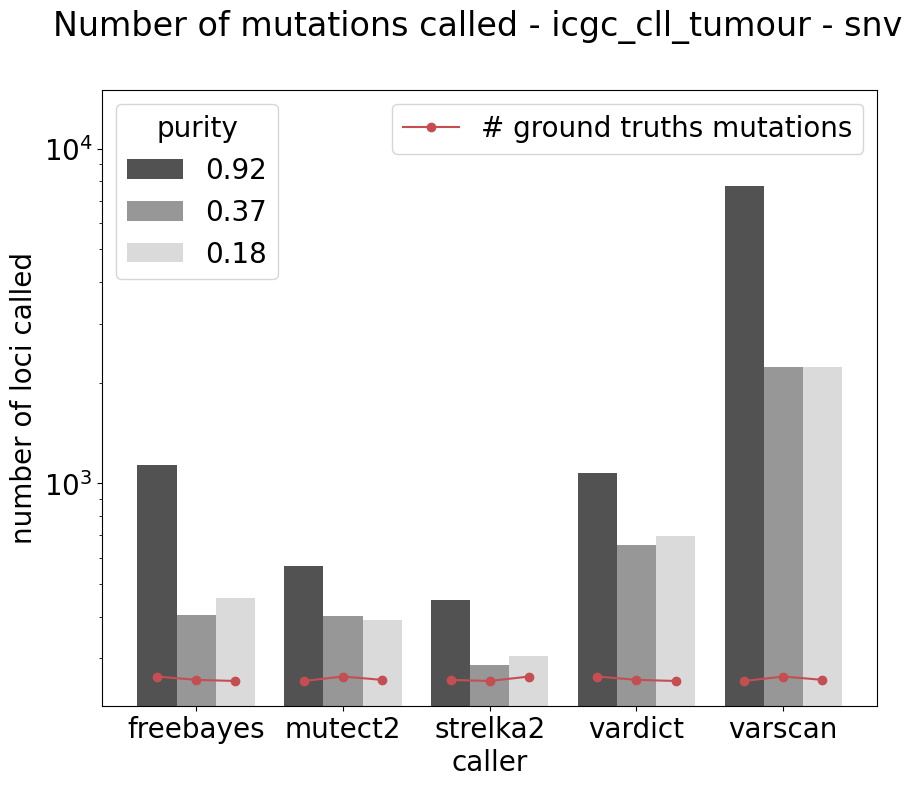

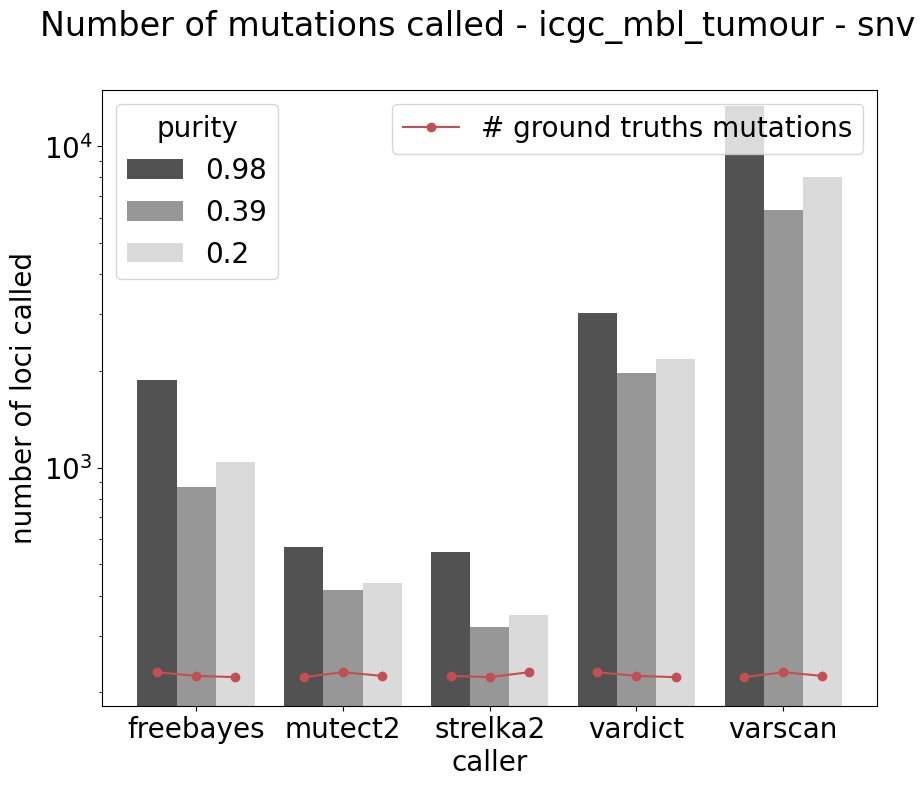

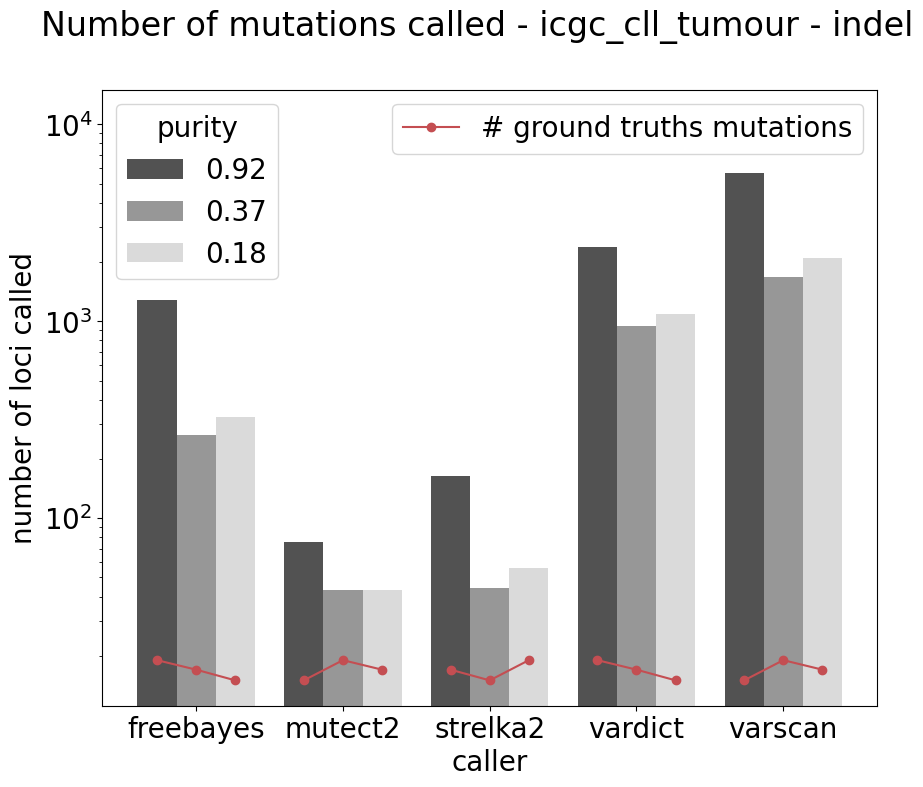

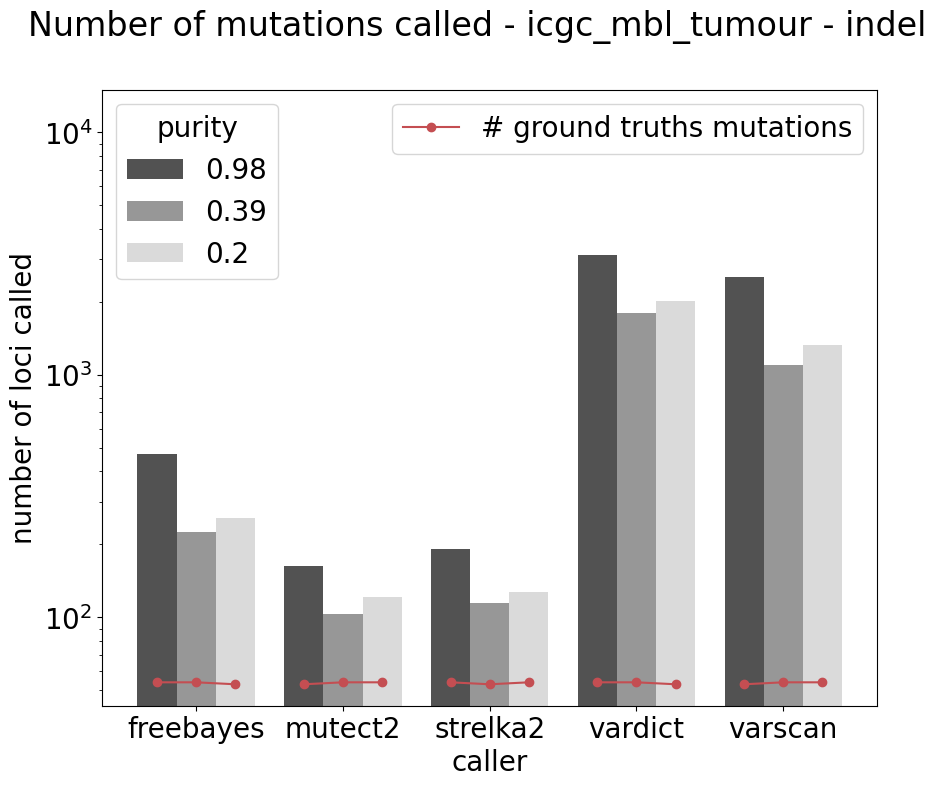

In [16]:
for muttype in config.muttype:
    for s, sample in enumerate(config.tissuebenchmark.samples):
        plt.figure(figsize=(10,8))
        ax = sns.barplot(x="caller", y="number of loci called", hue="purity", data=df[(df['mutation type'] == muttype) & (df['sample'] == sample)], ci=None, palette="Greys_r", log=True,
                        hue_order=[round(config.tissuebenchmark.purities[s]*config.tissuebenchmark.fractions[i], 2) for i in range(3)])
        leg1 = plt.legend(title='purity', loc=2)

        xcoords, ycoords = [], []
        for m,methods in enumerate(config.methods):
            for b, bar in enumerate(plots.patches):
                if b % len(config.methods) == m:
                    #print(b)
                    if len(xcoords) == 3:
                        xcoords, ycoords = [], []
                    xi = bar.get_x() + (bar.get_width() / 2)
                    yi = df[(df['sample'] == sample) & (df['mutation type'] == muttype) & (df['caller'] == config.methods[b//3]) & (df['purity'] == round(config.tissuebenchmark.purities[s]*config.tissuebenchmark.fractions[b%3], 2))]['number of mutations (ground truth)'].values[0]
                    xcoords.append(xi)
                    ycoords.append(yi)
                    if len(xcoords) == 3:
                        if m == 0:
                            redline = ax.plot(xcoords, ycoords, 'ro-', label='Number of ground truths mutations')
                        else:
                            ax.plot(xcoords, ycoords, 'ro-')
        plt.ylim([0,15000])
        plt.legend(redline, ['# ground truths mutations'], loc='upper right', bbox_to_anchor=(1, 1))
        plt.gca().add_artist(leg1)
        plt.suptitle('Number of mutations called - '+sample+' - '+muttype)
    

# Ratio performance attenuation

In [17]:
df = pd.DataFrame(columns=['sample', 'mutation type', 'caller', 'purity', 'metric', 'number of loci', 'rate',  'number of mutations (ground truth)']) #'TN', 'FP', 'FN', 'TP'])
metric = ['TN', 'FP', 'FN', 'TP']
c = 0
for muttype in config.muttype:
    for i, sample in enumerate(config.tissuebenchmark.samples):
        for method in config.tissuebenchmark.methods:
            print(muttype, sample, method)
            for f in config.tissuebenchmark.fractions:
                vcf_sample = df_table[(df_table['sample'] == sample) & (df_table['mutation type'] == muttype) & (df_table['purity'] == round(config.tissuebenchmark.purities[i]*f, 2))]
                ntruth = sum(vcf_sample['TRUTH'])
                tn, fp, fn, tp = confusion_matrix(vcf_sample['TRUTH'], vcf_sample[method], labels=[0,1]).ravel()
                tpfn = tp + fn
                tnfp = tn + fp
                for j, tfpn in enumerate([tn, fp, fn, tp]):
                    # df.loc[c, :] = [sample, muttype, method, round(config.tissuebenchmark.purities[i]*f, 2), tn, fp, fn, tp]
                    if j in [0, 1]:
                        df.loc[c, :] = [sample, muttype, method, round(config.tissuebenchmark.purities[i]*f, 2), metric[c%4], tfpn, tfpn/tnfp, ntruth]
                    else: # j in [2,3]
                        df.loc[c, :] = [sample, muttype, method, round(config.tissuebenchmark.purities[i]*f, 2), metric[c%4], tfpn, tfpn/tpfn, ntruth]
                    c += 1
                    
df = df[df['metric'] == 'TP']
df['TP/GT'] =  df['number of loci'].divide(df['number of mutations (ground truth)'], axis='index') 

df.head(20)

snv icgc_cll_tumour freebayes
snv icgc_cll_tumour mutect2
snv icgc_cll_tumour strelka2
snv icgc_cll_tumour vardict
snv icgc_cll_tumour varscan
snv icgc_mbl_tumour freebayes
snv icgc_mbl_tumour mutect2
snv icgc_mbl_tumour strelka2
snv icgc_mbl_tumour vardict
snv icgc_mbl_tumour varscan
indel icgc_cll_tumour freebayes
indel icgc_cll_tumour mutect2
indel icgc_cll_tumour strelka2
indel icgc_cll_tumour vardict
indel icgc_cll_tumour varscan
indel icgc_mbl_tumour freebayes
indel icgc_mbl_tumour mutect2
indel icgc_mbl_tumour strelka2
indel icgc_mbl_tumour vardict
indel icgc_mbl_tumour varscan


,sample,mutation type,caller,purity,metric,number of loci,rate,number of mutations (ground truth),TP/GT
3,icgc_cll_tumour,snv,freebayes,0.92,TP,231,0.871698,265,0.871698
7,icgc_cll_tumour,snv,freebayes,0.37,TP,207,0.805447,257,0.805447
11,icgc_cll_tumour,snv,freebayes,0.18,TP,215,0.830116,259,0.830116
15,icgc_cll_tumour,snv,mutect2,0.92,TP,252,0.950943,265,0.950943
19,icgc_cll_tumour,snv,mutect2,0.37,TP,227,0.883268,257,0.883268
23,icgc_cll_tumour,snv,mutect2,0.18,TP,225,0.868726,259,0.868726
27,icgc_cll_tumour,snv,strelka2,0.92,TP,254,0.958491,265,0.958491
31,icgc_cll_tumour,snv,strelka2,0.37,TP,241,0.937743,257,0.937743
35,icgc_cll_tumour,snv,strelka2,0.18,TP,248,0.957529,259,0.957529
39,icgc_cll_tumour,snv,vardict,0.92,TP,243,0.916981,265,0.916981


<Figure size 1200x600 with 0 Axes>

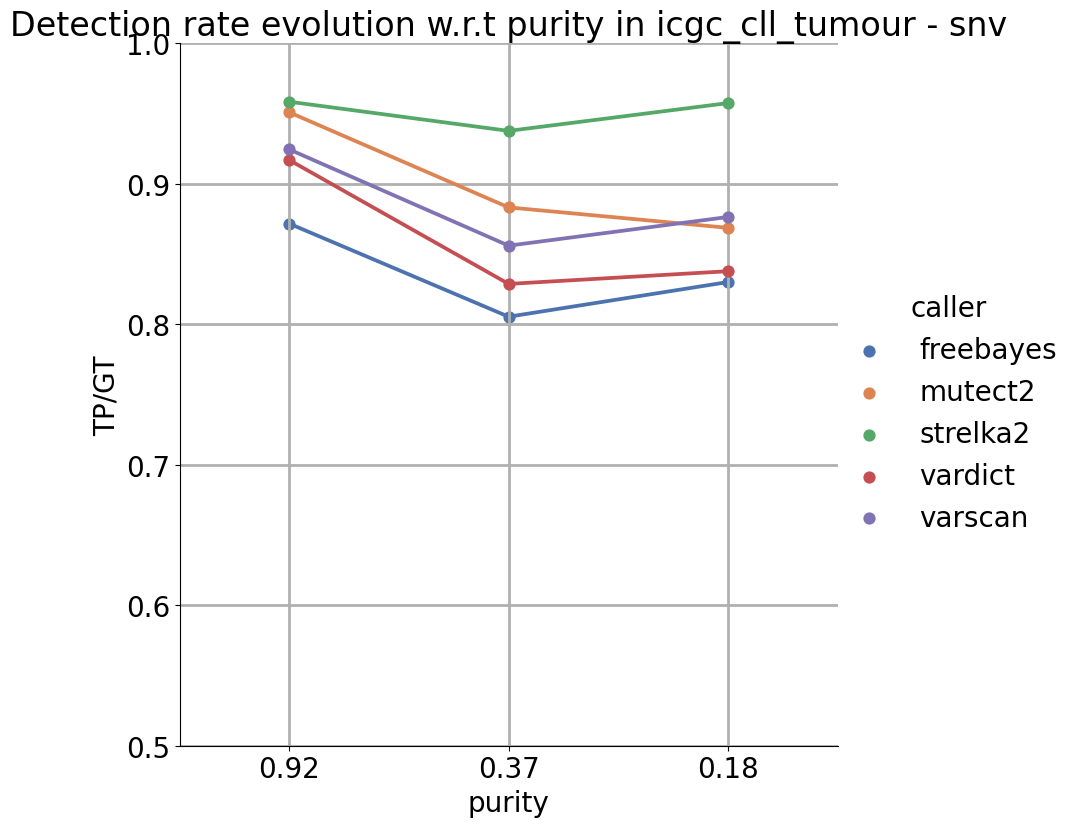

<Figure size 1200x600 with 0 Axes>

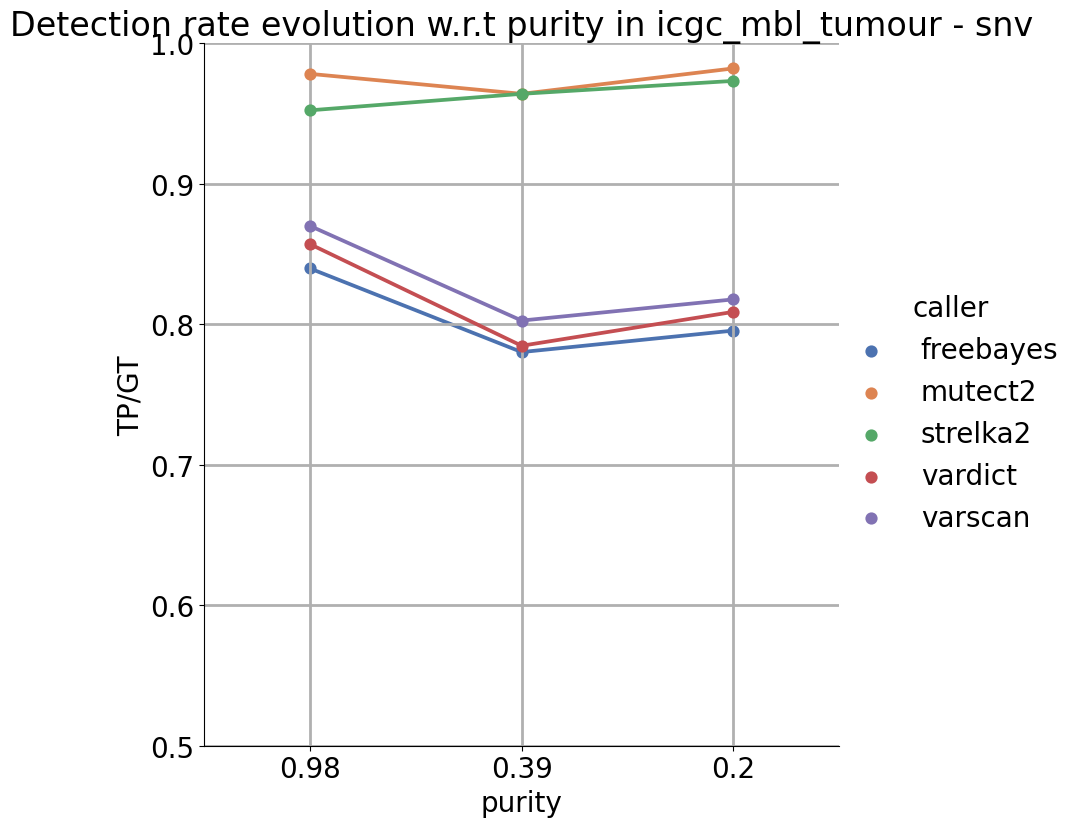

<Figure size 1200x600 with 0 Axes>

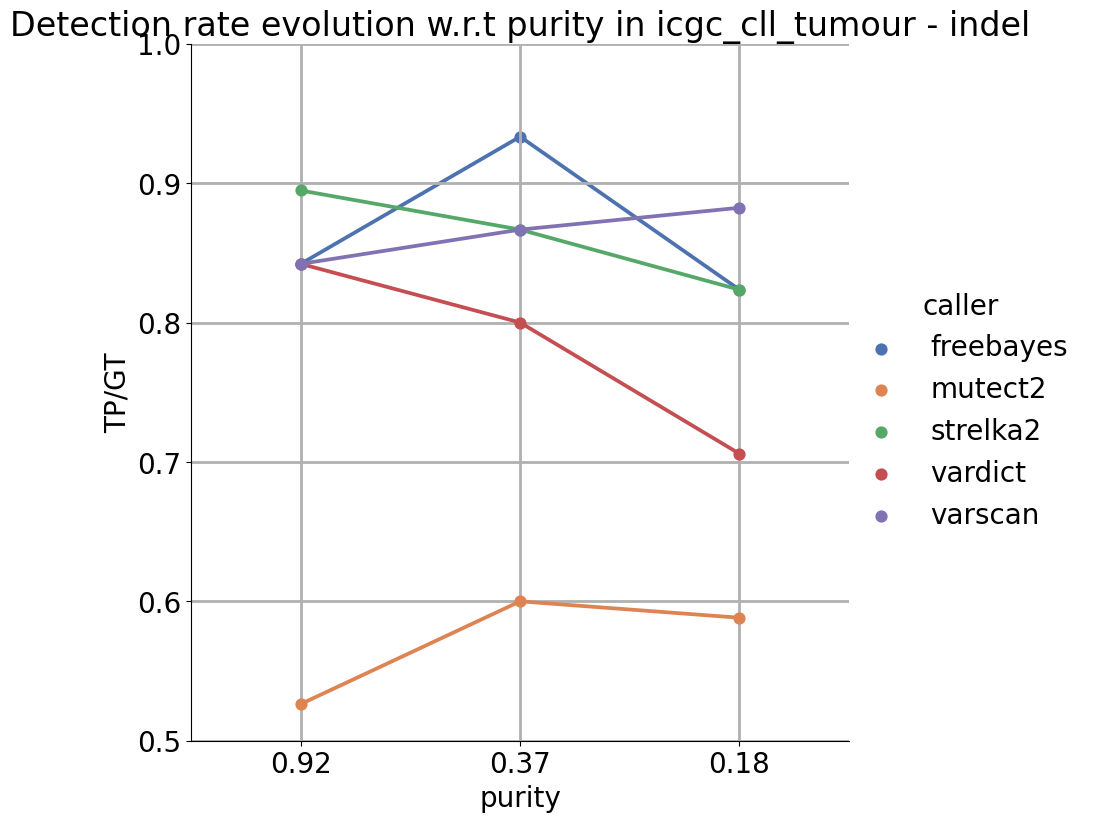

<Figure size 1200x600 with 0 Axes>

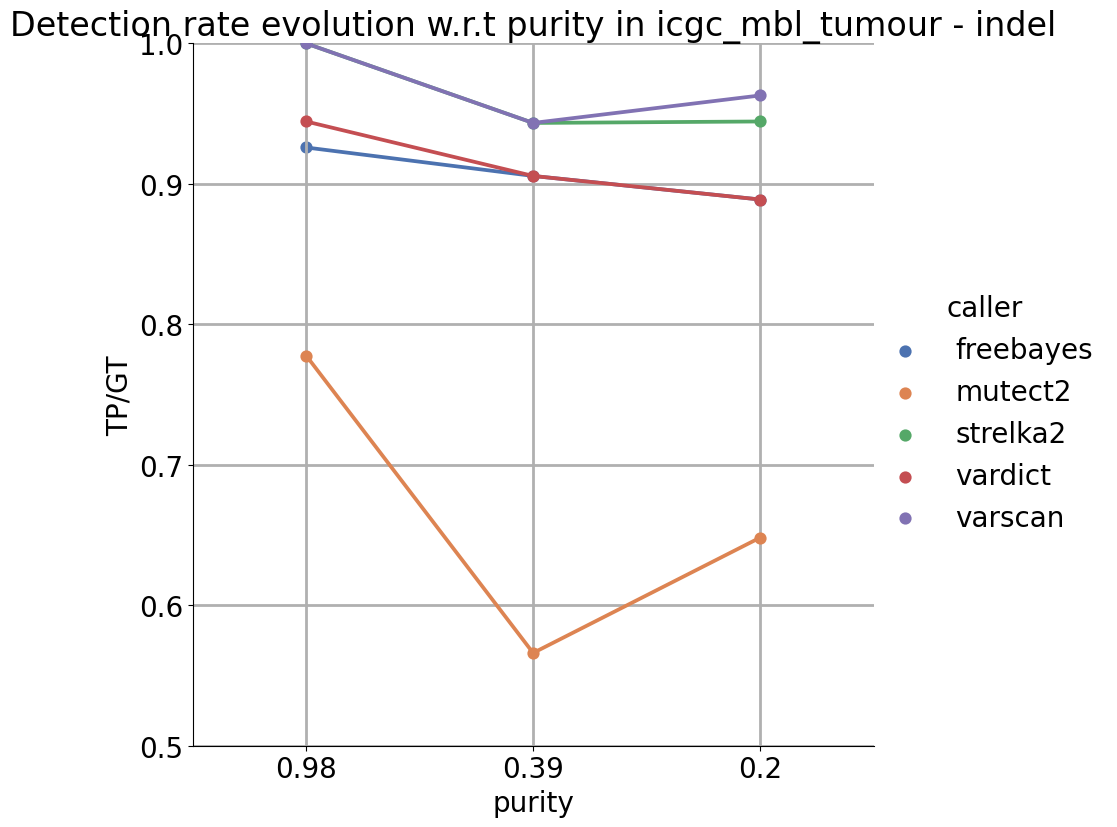

In [18]:
for muttype in config.muttype:
    for i, sample in enumerate(config.tissuebenchmark.samples):
        g = plt.figure(figsize=(12,6))
        g = sns.catplot(x='purity', y='TP/GT', hue='caller', data=df[(df['sample'] == sample) & (df['mutation type'] == muttype)], kind='point', height=8,
                        order=[round(config.tissuebenchmark.purities[i]*config.tissuebenchmark.fractions[f], 2) for f in range(3)])
        plt.title('Detection rate evolution w.r.t purity in '+sample+' - '+muttype)
        plt.grid() 
        plt.ylim([0.5,1])
        plt.savefig('figures/tissue_benchmark/'+sample+'_'+muttype+'_detectionrate',  bbox_inches='tight')

In [19]:
res = df
a = res[['sample', 'mutation type', 'caller', 'TP/GT', 'purity']][res['purity'] > 0.9].set_index(['sample', 'mutation type', 'caller']).drop('purity', axis=1)
b = res[['sample', 'mutation type', 'caller', 'TP/GT', 'purity']][res['purity'] <= 0.2].set_index(['sample', 'mutation type', 'caller']).drop('purity', axis=1)
res = (a-b).divide(a).reset_index()
res['TP/GT'] = 100*res['TP/GT']
res

,sample,mutation type,caller,TP/GT
0,icgc_cll_tumour,snv,freebayes,4.77026
1,icgc_cll_tumour,snv,mutect2,8.64589
2,icgc_cll_tumour,snv,strelka2,0.100325
3,icgc_cll_tumour,snv,vardict,8.63085
4,icgc_cll_tumour,snv,varscan,5.20054
5,icgc_mbl_tumour,snv,freebayes,5.27148
6,icgc_mbl_tumour,snv,mutect2,-0.39528
7,icgc_mbl_tumour,snv,strelka2,-2.2
8,icgc_mbl_tumour,snv,vardict,5.62963
9,icgc_mbl_tumour,snv,varscan,6.01658


<Figure size 2000x1200 with 0 Axes>

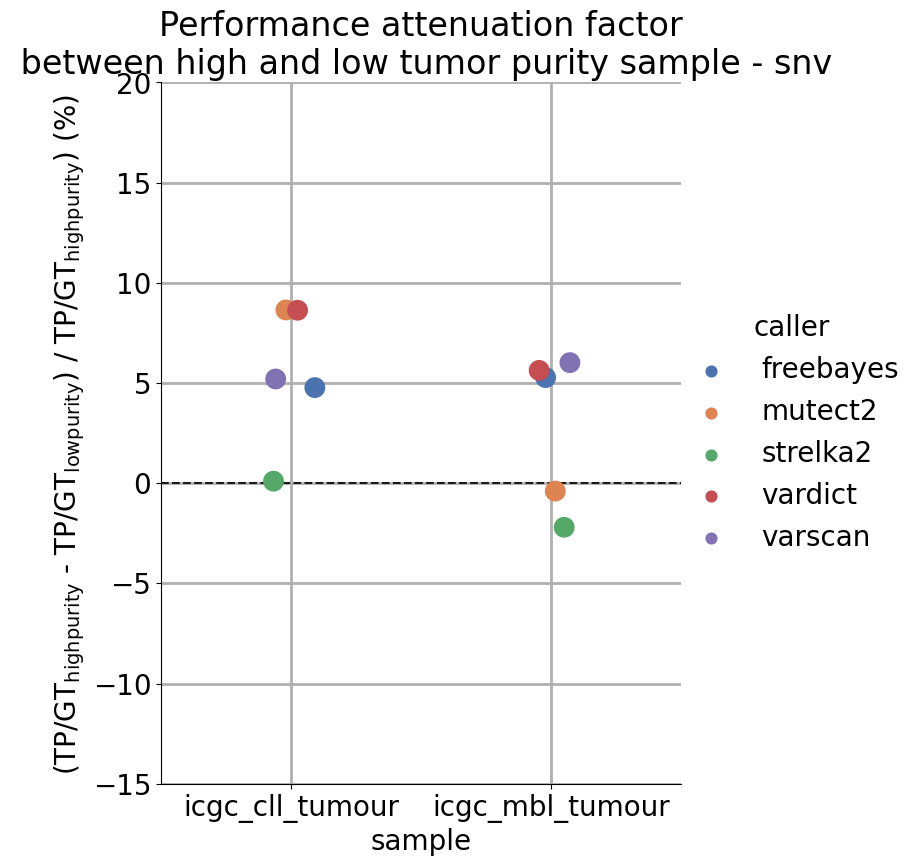

<Figure size 2000x1200 with 0 Axes>

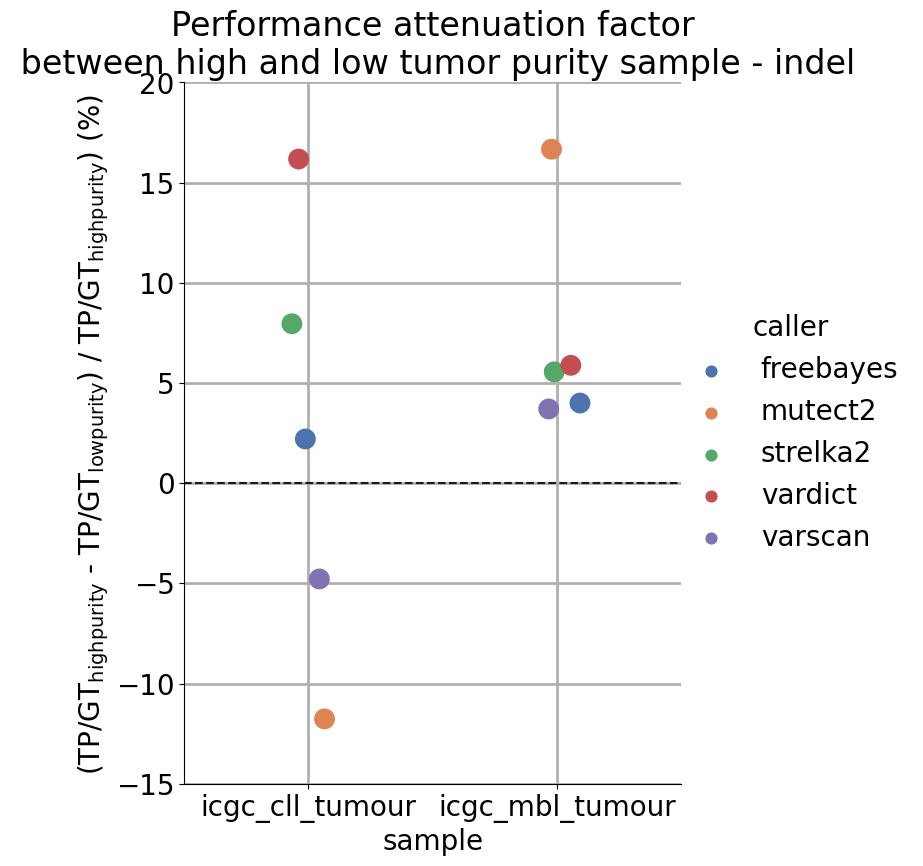

In [20]:
for muttype in config.muttype:
    plt.figure(figsize=(20,12))
    #sns.set_style("whitegrid")
    sns.catplot(y='TP/GT', x='sample', hue='caller', data=res[res['mutation type'] == muttype], height=8, aspect=0.8, s=15)
    plt.axhline(y=0, c='k', ls='--')
    plt.grid()
    plt.ylim([-15, 20])
    plt.ylabel('(TP/GT$_{\\rm{high purity}}$ - TP/GT$_{\\rm{low purity}}$) / TP/GT$_{\\rm{high purity}}$) (%) ')
    plt.title('Performance attenuation factor\n between high and low tumor purity sample - ' + muttype)
    plt.savefig('figures/tissue_benchmark/'+muttype+'_performanceattenuationfactor',  bbox_inches='tight')